In [121]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import mysql.connector
import shapefile as shp
import geopandas as gpd
from sklearn.metrics import mean_squared_error, r2_score
from sklearn. linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import pearsonr
from sklearn import linear_model, model_selection
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score,KFold,GridSearchCV
import shapefile as shp
import geopandas as gpd
from shapely.geometry import Point

In [224]:
os.chdir(r'C:\Users\ADMIN\Desktop\DS_Thesis')

I have uploaded the files to a database and then removed out few columns out of 202 columns for the analysis. Now we import those file by connecting to database server and join them.

In [122]:
## connecting to sql database
connection = mysql.connector.connect(
host = 'localhost',
port = int(3306),
user= 'newuser',
password = 'vrajesh@123',
db = 'tesco')

#querying two tables (IMD_Ranks and Tesco Grocery data)and joining them
query = "SELECT * FROM all_ranks JOIN year_lsoa_grocery ON all_ranks.lsoa11 = year_lsoa_grocery.lsoa11;"
data = pd.read_sql(query, connection)
connection.close

D:\anaconda\lib\site-packages\pandas\io\sql.py:762: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


<bound method CMySQLConnection.close of <mysql.connector.connection_cext.CMySQLConnection object at 0x000001D289A59EB0>>

In [123]:
data.shape

(4833, 116)

# we create classes just for the sake of clear and clean visualisation as there are huge numbers of LSOA regions

(array([ 934., 1220.,  933.,  743.,  582.,  421.]),
 array([  586.        ,  5938.33333333, 11290.66666667, 16643.        ,
        21995.33333333, 27347.66666667, 32700.        ]),
 <BarContainer object of 6 artists>)

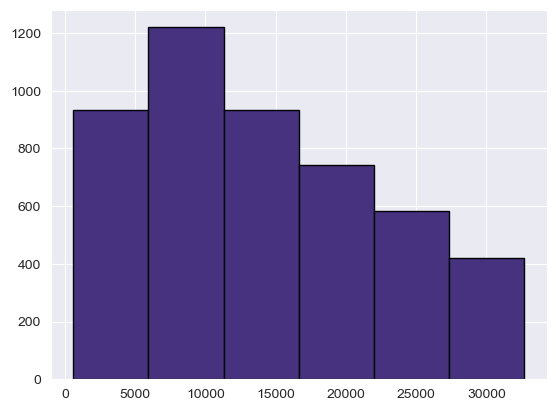

In [124]:
fig,ax = plt.subplots()
ax.hist(data['IMD_rank'],bins =6,edgecolor='black')

In [125]:
## we take number of categories as 6 by watching the distribution of IMD_rank
num_categories = 6

# Categorize 'IMD_Rank' into quantile-based categories
data['IMD_Category'] = pd.qcut(data['IMD_rank'], q=num_categories, duplicates='drop')
data['IMD_Category'] = data['IMD_Category'].astype('category').cat.rename_categories(['1-5k', '5k-10k', '10k-15k', '15k-20', '20k-25k','25k-32k'])

In [126]:
## saving the merged file inital copy for a backup 
data.to_csv(r'C:\Users\ADMIN\Desktop\DS_Thesis\mergerd.csv')

In [127]:
data.rename(columns={'lsoa11':'area_id'},inplace=True)
data.head()

area_id           LSOA name (2011) Local Authority District code (2013)  \
0  E01000027  Barking and Dagenham 001A                            E09000002   
1  E01000028  Barking and Dagenham 001B                            E09000002   
2  E01000029  Barking and Dagenham 001C                            E09000002   
3  E01000030  Barking and Dagenham 001D                            E09000002   
4  E01000031  Barking and Dagenham 002A                            E09000002   

  Local Authority District name (2013)  \
0                 Barking and Dagenham   
1                 Barking and Dagenham   
2                 Barking and Dagenham   
3                 Barking and Dagenham   
4                 Barking and Dagenham   

   Index of Multiple Deprivation (IMD) Score  IMD_rank  IMD_decile  \
0                                     41.997      3924           2   
1                                     43.130      3617           2   
2                                     26.669      9890           4   
3                                     41.284      4130           2   
4                                     25.078     10820           4   

   Income Score (rate)  Income Rank  Income Decile  ...  population    male  \
0                0.295         3530              2  ...      1858.0   866.0   
1                0.324         2540              1  ...      1629.0   753.0   
2                0.139        13523              5  ...      1737.0   868.0   
3                0.314         2853              1  ...      2155.0  1062.0   
4                0.143        13154              5  ...      1716.0   853.0   

   female  age_0_17  age_18_64  age_65+    avg_age  area_sq_km  \
0   992.0     568.0     1075.0    215.0  34.376211        1.47   
1   876.0     509.0      917.0    203.0  33.862492        0.14   
2   869.0     366.0      923.0    448.0  43.012090        0.26   
3  1093.0     707.0     1236.0    212.0  31.882135        0.29   
4   863.0     413.0     1047.0    256.0  37.404429        0.84   

   people_per_sq_km  IMD_Category  
0            1260.0          1-5k  
1           11328.0          1-5k  
2            6761.0       10k-15k  
3            7527.0          1-5k  
4            2034.0       10k-15k  

[5 rows x 117 columns]

In [128]:
##Importing the shape file.
fp = "C:/Users/ADMIN/Desktop/DS_Thesis/statistical-gis-boundaries-london/ESRI/LSOA_2011_London_gen_MHW.shp"
shp_gdf = gpd.read_file(fp)
shp_gdf.keys()

Index(['LSOA11CD', 'LSOA11NM', 'MSOA11CD', 'MSOA11NM', 'LAD11CD', 'LAD11NM',
       'RGN11CD', 'RGN11NM', 'USUALRES', 'HHOLDRES', 'COMESTRES', 'POPDEN',
       'HHOLDS', 'AVHHOLDSZ', 'geometry'],
      dtype='object')

In [129]:
#importing the saved merged file
dataframe = pd.read_csv(r'C:\Users\ADMIN\Desktop\DS_Thesis\mergerd.csv')
dataframe.head()

Unnamed: 0     lsoa11           LSOA name (2011)  \
0           0  E01000027  Barking and Dagenham 001A   
1           1  E01000028  Barking and Dagenham 001B   
2           2  E01000029  Barking and Dagenham 001C   
3           3  E01000030  Barking and Dagenham 001D   
4           4  E01000031  Barking and Dagenham 002A   

  Local Authority District code (2013) Local Authority District name (2013)  \
0                            E09000002                 Barking and Dagenham   
1                            E09000002                 Barking and Dagenham   
2                            E09000002                 Barking and Dagenham   
3                            E09000002                 Barking and Dagenham   
4                            E09000002                 Barking and Dagenham   

   Index of Multiple Deprivation (IMD) Score  IMD_rank  IMD_decile  \
0                                     41.997      3924           2   
1                                     43.130      3617           2   
2                                     26.669      9890           4   
3                                     41.284      4130           2   
4                                     25.078     10820           4   

   Income Score (rate)  Income Rank  ...  population    male  female  \
0                0.295         3530  ...      1858.0   866.0   992.0   
1                0.324         2540  ...      1629.0   753.0   876.0   
2                0.139        13523  ...      1737.0   868.0   869.0   
3                0.314         2853  ...      2155.0  1062.0  1093.0   
4                0.143        13154  ...      1716.0   853.0   863.0   

   age_0_17  age_18_64  age_65+    avg_age  area_sq_km  people_per_sq_km  \
0     568.0     1075.0    215.0  34.376211        1.47            1260.0   
1     509.0      917.0    203.0  33.862492        0.14           11328.0   
2     366.0      923.0    448.0  43.012090        0.26            6761.0   
3     707.0     1236.0    212.0  31.882135        0.29            7527.0   
4     413.0     1047.0    256.0  37.404429        0.84            2034.0   

   IMD_Category  
0          1-5k  
1          1-5k  
2       10k-15k  
3          1-5k  
4       10k-15k  

[5 rows x 118 columns]

In [130]:
# merging both files
merged2= shp_gdf.set_index('LSOA11CD').join(dataframe.set_index('lsoa11'))

In [131]:
merged2.head()

LSOA11NM   MSOA11CD                  MSOA11NM  \
LSOA11CD                                                                    
E01000001        City of London 001A  E02000001        City of London 001   
E01000002        City of London 001B  E02000001        City of London 001   
E01000003        City of London 001C  E02000001        City of London 001   
E01000005        City of London 001E  E02000001        City of London 001   
E01000006  Barking and Dagenham 016A  E02000017  Barking and Dagenham 016   

             LAD11CD               LAD11NM    RGN11CD RGN11NM  USUALRES  \
LSOA11CD                                                                  
E01000001  E09000001        City of London  E12000007  London      1465   
E01000002  E09000001        City of London  E12000007  London      1436   
E01000003  E09000001        City of London  E12000007  London      1346   
E01000005  E09000001        City of London  E12000007  London       985   
E01000006  E09000002  Barking and Dagenham  E12000007  London      1703   

           HHOLDRES  COMESTRES  ...  population    male  female age_0_17  \
LSOA11CD                        ...                                        
E01000001      1465          0  ...      1296.0   685.0   611.0    179.0   
E01000002      1436          0  ...      1156.0   616.0   540.0    197.0   
E01000003      1250         96  ...      1350.0   713.0   637.0    152.0   
E01000005       985          0  ...      1121.0   604.0   517.0    294.0   
E01000006      1699          4  ...      2040.0  1040.0  1000.0    563.0   

           age_18_64 age_65+    avg_age area_sq_km  people_per_sq_km  \
LSOA11CD                                                               
E01000001      766.0   351.0  48.293981       0.13            9985.0   
E01000002      656.0   303.0  47.398789       0.23            5061.0   
E01000003      850.0   348.0  48.360741       0.06           22843.0   
E01000005      675.0   152.0  35.611954       0.19            5912.0   
E01000006     1317.0   160.0  32.080392       0.15           13915.0   

           IMD_Category  
LSOA11CD                 
E01000001       25k-32k  
E01000002       25k-32k  
E01000003        15k-20  
E01000005       10k-15k  
E01000006       10k-15k  

[5 rows x 131 columns]

In [132]:
## check for null values
merged2.isna().sum()

LSOA11NM            0
MSOA11CD            0
MSOA11NM            0
LAD11CD             0
LAD11NM             0
                   ..
age_65+             2
avg_age             2
area_sq_km          2
people_per_sq_km    2
IMD_Category        2
Length: 131, dtype: int64

In [133]:
## dropping null values
merged2= merged2.dropna()

In [134]:
#writing a function that finds correlation bw 2 variables
def calculate_corr(data,column1,column2):
    correlation , _ = pearsonr(data[column1],data[column2])
    print('The correlation of' ,column1 , 'with' ,column2,'is:',correlation)
    return correlation

In [135]:
calculate_corr(merged2,'IMD_rank','fibre')
calculate_corr(merged2,'IMD_rank','f_water')

The correlation of IMD_rank with fibre is: 0.4773571664970097
The correlation of IMD_rank with f_water is: -0.5320638697234845


-0.5320638697234845

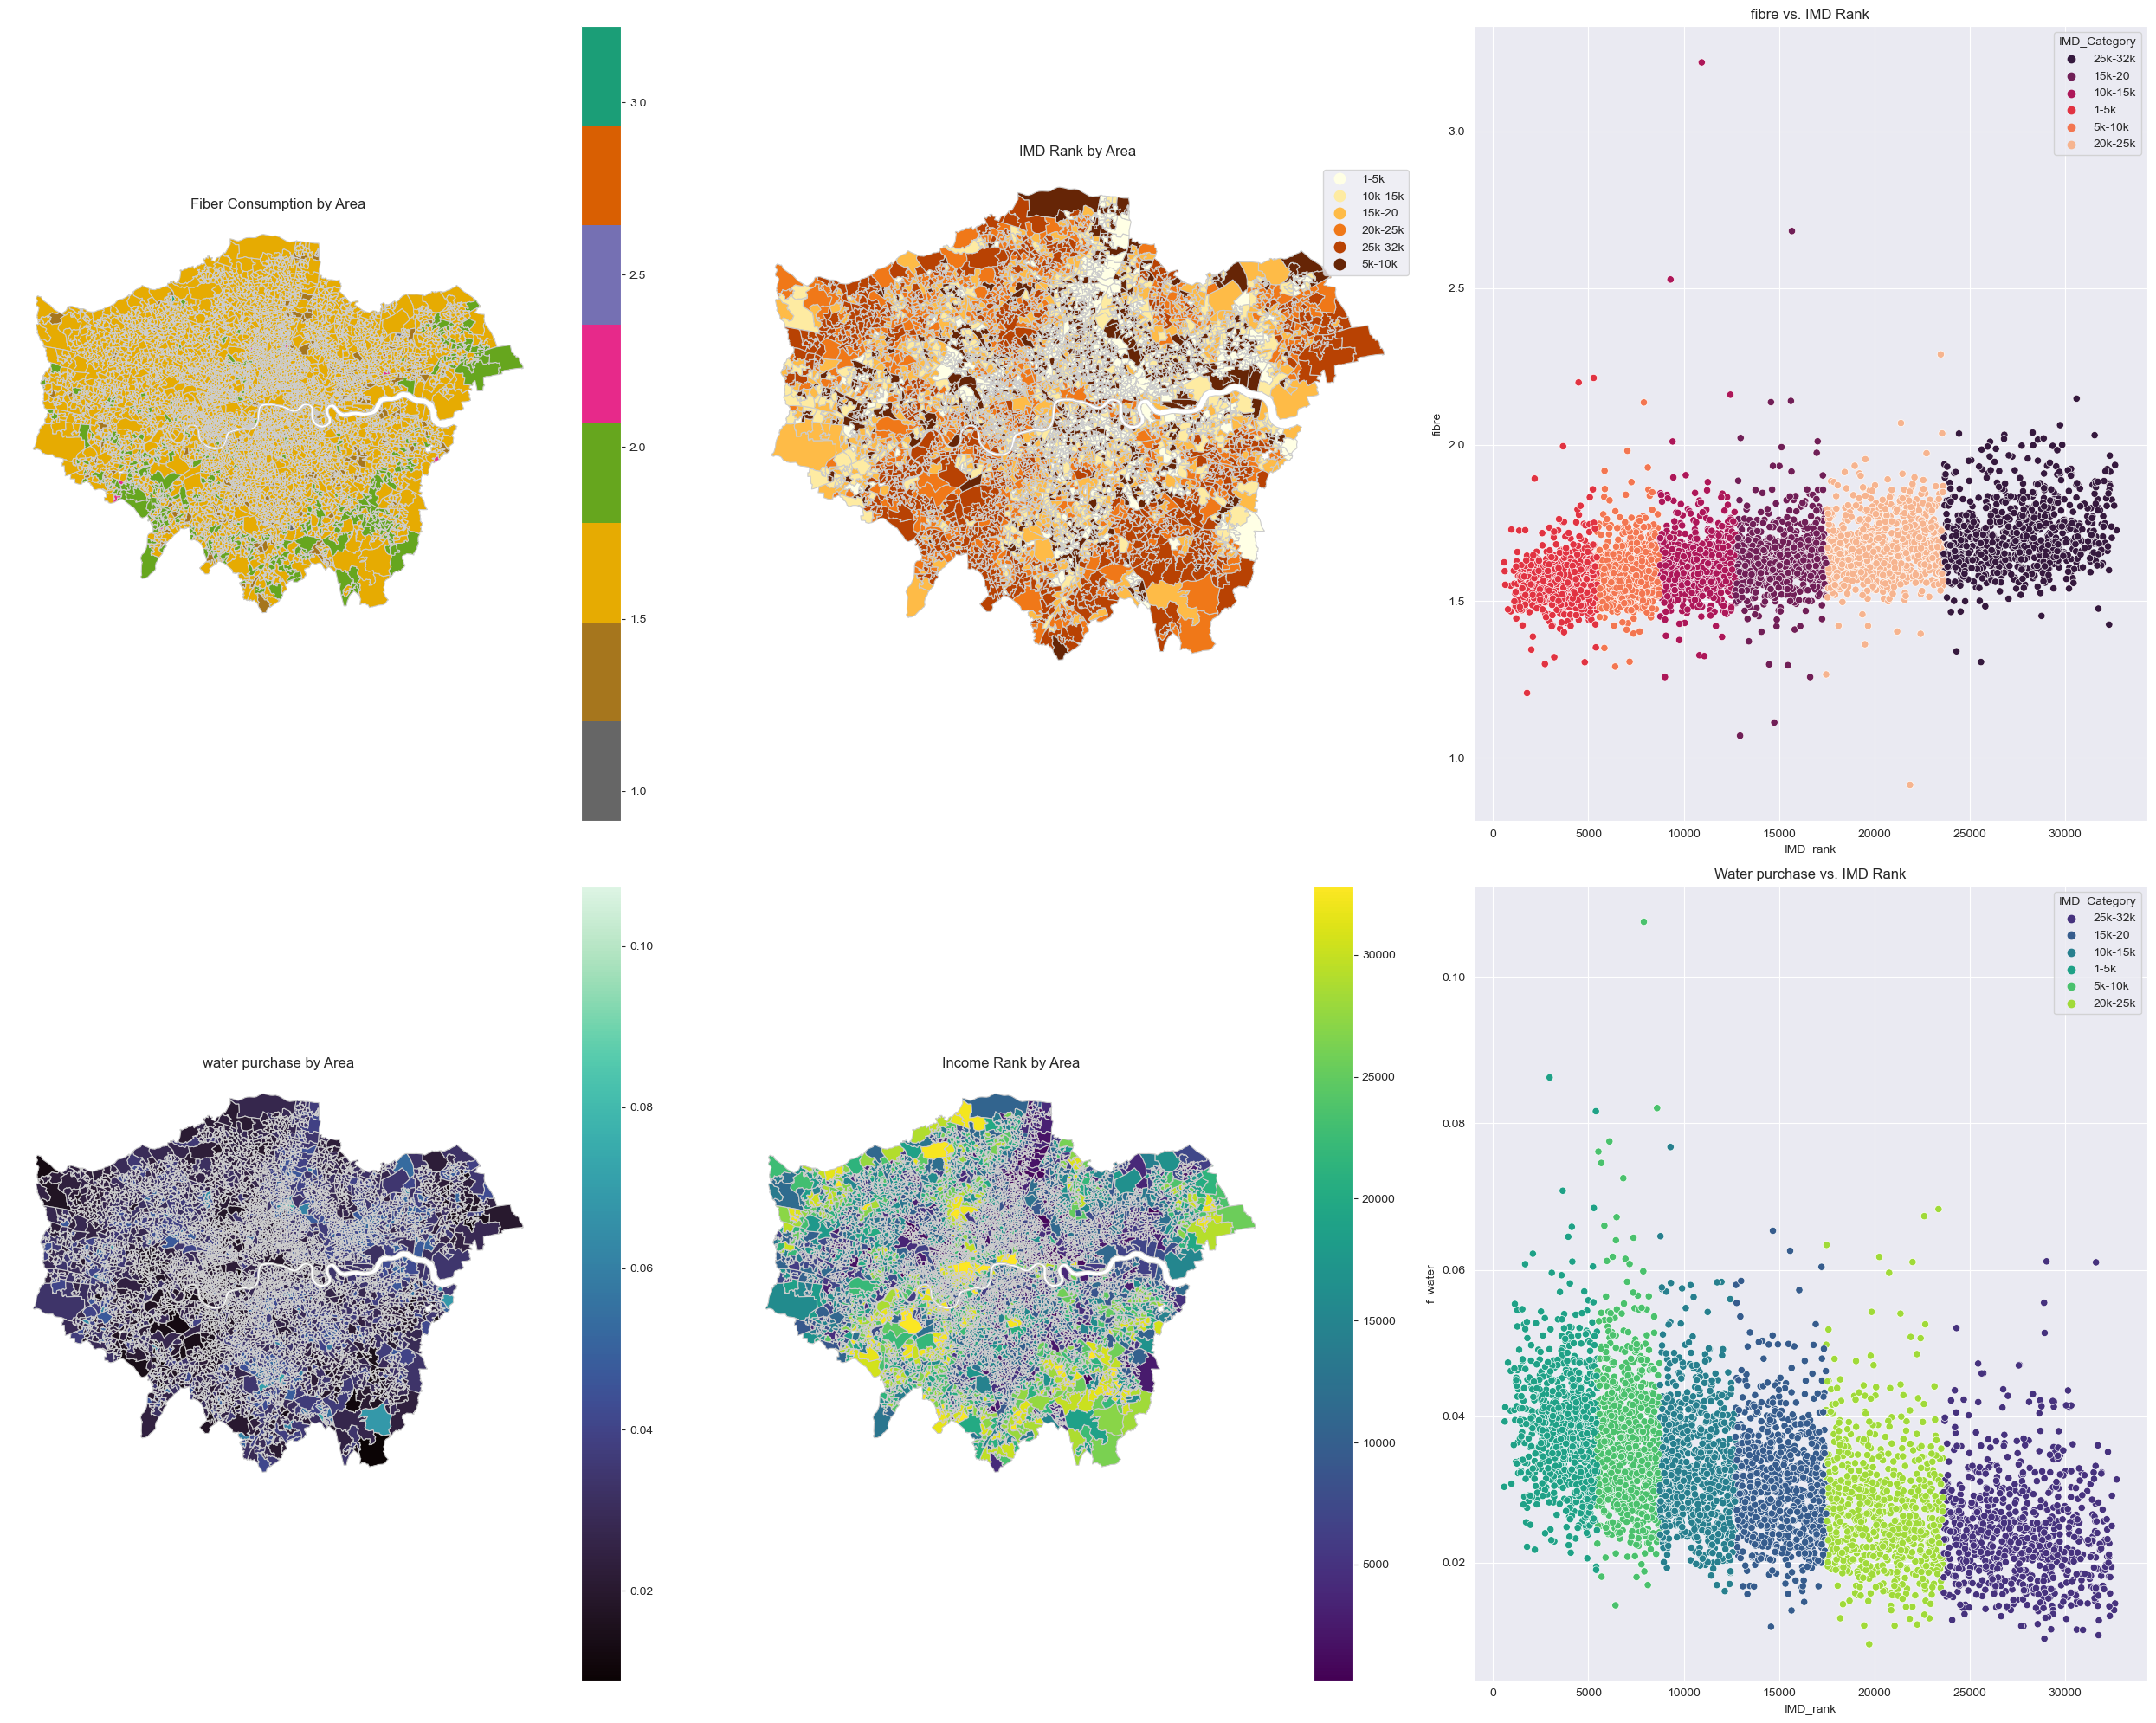

In [136]:
# Set up the subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(25, 20))

# Plot the fiber consumption
sns.set_palette('husl')
merged2.plot(column='fibre', cmap='Dark2_r', linewidth=0.8, ax=axes[0][0], edgecolor='0.8', legend=True)
axes[0][0].axis('off')
axes[0][0].set_title('Fiber Consumption by Area')

# Plot the IMD Rank
merged2.plot(column='IMD_Category', cmap='YlOrBr', linewidth=0.8, ax=axes[0][1], edgecolor='0.8', legend=True)
axes[0][1].axis('off')
axes[0][1].set_title('IMD Rank by Area')

# Additional plot: fibre vs. IMD_rank
sns.set_palette("rocket")
sns.scatterplot(data=merged2, x="IMD_rank", y='fibre', hue='IMD_Category', ax=axes[0][2])
axes[0][2].set_title('fibre vs. IMD Rank')

# Plot the water consumption
sns.set_palette('husl')
merged2.plot(column='f_water', cmap='mako', linewidth=0.8, ax=axes[1][0], edgecolor='0.8', legend=True)
axes[1][0].axis('off')
axes[1][0].set_title('water purchase by Area')

# Plot the IMD Rank
merged2.plot(column='Income Rank', cmap='viridis', linewidth=0.8, ax=axes[1][1], edgecolor='0.8', legend=True)
axes[1][1].axis('off')
axes[1][1].set_title('Income Rank by Area')

# Additional plot: f_water vs. IMD_rank
sns.set_palette("viridis")
sns.scatterplot(data=merged2, x="IMD_rank", y='f_water', hue='IMD_Category', ax=axes[1][2])
axes[1][2].set_title('Water purchase vs. IMD Rank')

# Adjust the spacing between subplots
plt.tight_layout()

#saving fig
plt.savefig('IMD_visual.jpg')

# Show the subplots
plt.show()


From the above we can see that

- Fibre consumption is more in areas that are least deprived
- purchase of water is more where the income is low and also the area is more deprived

## preprocessing merged data for our model

In [137]:
merged2.head()
for col in merged2.columns:
    print (col)

LSOA11NM
MSOA11CD
MSOA11NM
LAD11CD
LAD11NM
RGN11CD
RGN11NM
USUALRES
HHOLDRES
COMESTRES
POPDEN
HHOLDS
AVHHOLDSZ
geometry
Unnamed: 0
LSOA name (2011)
Local Authority District code (2013)
Local Authority District name (2013)
Index of Multiple Deprivation (IMD) Score
IMD_rank
IMD_decile
Income Score (rate)
Income Rank
Income Decile
Employment Score (rate)
Employment Rank
Employment Decile
Education, Skills and Training Score
Education_Skills_Training Rank
Education_Skills_Trainingdecile
Health Deprivation and Disability Score
Health Deprivation and Disability Rank
Health Deprivation and Disability Decile
Crime Score
Crime Rank
Crime Decile
Barriers to Housing and Services Score
Barriers to Housing and Services Rank
Barriers to Housing and Services Decile
Living Environment Score
Living Environment Rank
Living Environment Decile
Income Deprivation Affecting Children Index (IDACI) Score (rate)
Income Deprivation Affecting Children Index (IDACI) Rank
Income Deprivation Affecting Children Inde

In [138]:
## we only select the required variables for our models

df_merge = merged2[['IMD_rank','weight','volume','energy_tot','fat','saturate','salt','sugar','protein','carb','fibre','alcohol','f_beer','f_dairy','f_eggs','f_fats_oils','f_fish','f_fruit_veg','f_grains','f_meat_red','f_poultry','f_readymade','f_sauces','f_soft_drinks','f_spirits','f_sweets','f_tea_coffee','f_water','f_wine','male','female','age_0_17','age_18_64','age_65+','avg_age', 'num_transactions']]

In [139]:
df_merge.head()

IMD_rank  weight      volume  energy_tot       fat  saturate  \
LSOA11CD                                                                  
E01000001   29111.0   308.0   97.218600  163.985327  8.535149  3.498749   
E01000002   28855.0   314.0   88.262314  157.572172  8.054729  3.159077   
E01000003   14621.0   315.0  102.240558  163.321285  8.153757  3.375788   
E01000005   10285.0   356.0  113.968805  169.339310  8.339058  3.319496   
E01000006   12345.0   451.0  133.322097  190.310015  9.622101  3.864007   

               salt      sugar   protein       carb  ...  f_tea_coffee  \
LSOA11CD                                             ...                 
E01000001  0.529092   9.213734  5.262429  15.158014  ...      0.004811   
E01000002  0.520153   8.337412  5.351774  14.358466  ...      0.004962   
E01000003  0.486434   9.414937  5.029519  15.820254  ...      0.004354   
E01000005  0.561716   9.603258  5.230254  17.126487  ...      0.005047   
E01000006  0.558866  11.355115  5.026295  19.903063  ...      0.006838   

            f_water    f_wine    male  female  age_0_17  age_18_64  age_65+  \
LSOA11CD                                                                      
E01000001  0.018086  0.034768   685.0   611.0     179.0      766.0    351.0   
E01000002  0.023886  0.040647   616.0   540.0     197.0      656.0    303.0   
E01000003  0.023708  0.046376   713.0   637.0     152.0      850.0    348.0   
E01000005  0.028512  0.016832   604.0   517.0     294.0      675.0    152.0   
E01000006  0.038735  0.005301  1040.0  1000.0     563.0     1317.0    160.0   

             avg_age  num_transactions  
LSOA11CD                                
E01000001  48.293981          106255.0  
E01000002  47.398789           66016.0  
E01000003  48.360741           96567.0  
E01000005  35.611954          234504.0  
E01000006  32.080392           68269.0  

[5 rows x 36 columns]

In [140]:
df_merge= df_merge.dropna()

In [141]:
print('Intially we have',len(df_merge.columns), 'features, that are:')
print(df_merge.columns.to_list())

Intially we have 36 features, that are:
['IMD_rank', 'weight', 'volume', 'energy_tot', 'fat', 'saturate', 'salt', 'sugar', 'protein', 'carb', 'fibre', 'alcohol', 'f_beer', 'f_dairy', 'f_eggs', 'f_fats_oils', 'f_fish', 'f_fruit_veg', 'f_grains', 'f_meat_red', 'f_poultry', 'f_readymade', 'f_sauces', 'f_soft_drinks', 'f_spirits', 'f_sweets', 'f_tea_coffee', 'f_water', 'f_wine', 'male', 'female', 'age_0_17', 'age_18_64', 'age_65+', 'avg_age', 'num_transactions']


In [142]:
df_merge.describe()

IMD_rank       weight       volume   energy_tot          fat  \
count   4833.000000  4833.000000  4833.000000  4833.000000  4833.000000   
mean   14060.020277   371.572522   109.611387   180.719900     9.049939   
std     8234.616486    52.849873    16.581778    10.742971     0.605291   
min      586.000000   164.000000    56.407704   119.457654     4.681363   
25%     7053.000000   334.000000    98.558263   174.485871     8.722714   
50%    12698.000000   373.000000   107.994404   180.183302     8.990191   
75%    20327.000000   409.000000   119.148316   186.345201     9.310919   
max    32700.000000   745.000000   241.418412   294.768538    16.909872   

          saturate         salt        sugar      protein         carb  ...  \
count  4833.000000  4833.000000  4833.000000  4833.000000  4833.000000  ...   
mean      3.543149     0.579034    10.316952     5.262559    18.383650  ...   
std       0.300334     0.051309     1.265143     0.319378     1.891362  ...   
min       1.497640     0.319694     7.227193     2.760256    12.922567  ...   
25%       3.388898     0.547077     9.490628     5.099913    17.227434  ...   
50%       3.519294     0.578475    10.134563     5.298949    18.360690  ...   
75%       3.667720     0.610903    10.959425     5.463299    19.443086  ...   
max       7.974305     1.084296    31.643724     7.771180    47.383776  ...   

       f_tea_coffee      f_water       f_wine         male       female  \
count   4833.000000  4833.000000  4833.000000  4833.000000  4833.000000   
mean       0.006048     0.031686     0.015779   890.591558   902.106145   
std        0.002557     0.009281     0.008370   199.136562   178.382182   
min        0.000680     0.008876     0.000923   316.000000   298.000000   
25%        0.004906     0.024966     0.009607   769.000000   801.000000   
50%        0.005740     0.030866     0.014300   855.000000   877.000000   
75%        0.006730     0.037358     0.020157   970.000000   976.000000   
max        0.070912     0.107509     0.070601  5138.000000  4413.000000   

          age_0_17    age_18_64      age_65+      avg_age  num_transactions  
count  4833.000000  4833.000000  4833.000000  4833.000000      4.833000e+03  
mean    403.702255  1181.990482   207.004966    36.221621      1.248086e+05  
std     131.871421   308.545341    82.817188     3.755610      1.443275e+05  
min      51.000000   346.000000    19.000000    25.015936      2.406000e+03  
25%     317.000000   988.000000   148.000000    33.642211      2.409500e+04  
50%     385.000000  1124.000000   194.000000    35.822951      7.518200e+04  
75%     472.000000  1305.000000   255.000000    38.466194      1.694620e+05  
max    1789.000000  7548.000000   732.000000    55.253532      1.027193e+06  

[8 rows x 36 columns]

In [143]:
# As the variance is very high which is seen above so we need to normalize the data 
# lets write a fucntion for log normalization or standardization of dataset
def normalize_with_standard_scaler(data):
    scaler = StandardScaler()
    normalized_data = scaler.fit_transform(data)
    normalized_df = pd.DataFrame(normalized_data, columns=data.columns)
    return normalized_df

def normalize_with_minmax_scaler(data):
    scaler = MinMaxScaler()
    normalized_data = scaler.fit_transform(data)
    normalized_df = pd.DataFrame(normalized_data, columns=data.columns)
    return normalized_df

In [144]:
# normalizing the data with standard scaler
df_imd_normalized=normalize_with_standard_scaler(df_merge)
df_imd_normalized.head()

IMD_rank    weight    volume  energy_tot       fat  saturate      salt  \
0  1.827958 -1.203013 -0.747451   -1.557884 -0.850572 -0.147851 -0.973464   
1  1.796867 -1.089472 -1.287635   -2.154909 -1.644355 -1.278950 -1.147687   
2  0.068132 -1.070549 -0.444560   -1.619702 -1.480735 -0.557309 -1.804939   
3 -0.458480 -0.294686  0.262811   -1.059462 -1.174567 -0.744758 -0.337570   
4 -0.208291  1.503044  1.430074    0.892780  0.945366  1.068447 -0.393114   

      sugar   protein      carb  ...  f_tea_coffee   f_water    f_wine  \
0 -0.872100 -0.000407 -1.705633  ...     -0.483753 -1.465517  2.268967   
1 -1.564838  0.279369 -2.128413  ...     -0.424458 -0.840574  2.971383   
2 -0.713048 -0.729742 -1.355457  ...     -0.662248 -0.859752  3.656004   
3 -0.564179 -0.101159 -0.664755  ...     -0.391317 -0.342016  0.125822   
4  0.820674 -0.739838  0.803426  ...      0.309185  0.759578 -1.251886   

       male    female  age_0_17  age_18_64   age_65+   avg_age  \
0 -1.032522 -1.632093 -1.704126  -1.348371  1.738889  3.214820   
1 -1.379053 -2.030156 -1.567615  -1.704919  1.159240  2.976434   
2 -0.891900 -1.486323 -1.908892  -1.076097  1.702661  3.232598   
3 -1.439320 -2.159106 -0.831974  -1.643334 -0.664242 -0.162352   
4  0.750359  0.548844  1.208103   0.437613 -0.567634 -1.102792   

   num_transactions  
0         -0.128565  
1         -0.407398  
2         -0.195697  
3          0.760124  
4         -0.391786  

[5 rows x 36 columns]

In [145]:
X_1 = df_imd_normalized.drop('IMD_rank',axis=1)
y_1 = df_imd_normalized['IMD_rank']
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X_1, y_1, test_size=0.3, random_state=42)

In [146]:
X_train_1.shape ,  X_test_1.shape

((3383, 35), (1450, 35))

In [147]:
### we write a function for linear regression model
from sklearn import linear_model, model_selection
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score,KFold,GridSearchCV

def linear_regression(X_train, y_train, X_test, y_test):
    linear_model = LinearRegression()
    linear_model = linear_model.fit(X_train, y_train)
    linear_model_score = linear_model.score(X_test,y_test)

    # Make predictions on train set and evaluate the model
    y_train_pred = linear_model.predict(X_train)
    r_train = r2_score(y_train, y_train_pred)
    print("R2 score (train):", r_train)

    # Make predictions on test set and evaluate the model
    y_test_pred = linear_model.predict(X_test)
    r_test = r2_score(y_test, y_test_pred)
    print("R2 score (test):", r_test)

    print(f"Mean squared error: {mean_squared_error(y_test, y_test_pred,squared=False):.3f}")


    print('model score',linear_model_score)

    
    
    
    # Plot scatter plot for actual and predicted values
    plt.scatter(y_test, y_test_pred, color='green', alpha=0.5)
    plt.plot([np.min(y_test), np.max(y_test)], [np.min(y_test), np.max(y_test)], color='red')  # Add a diagonal line for perfect fit
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Scatter Plot: Actual vs. Predicted')
    plt.show()
    return y_test_pred
    return linear_model

R2 score (train): 0.6101268791745567
R2 score (test): 0.5982978052105459
Mean squared error: 0.626
model score 0.5982978052105459


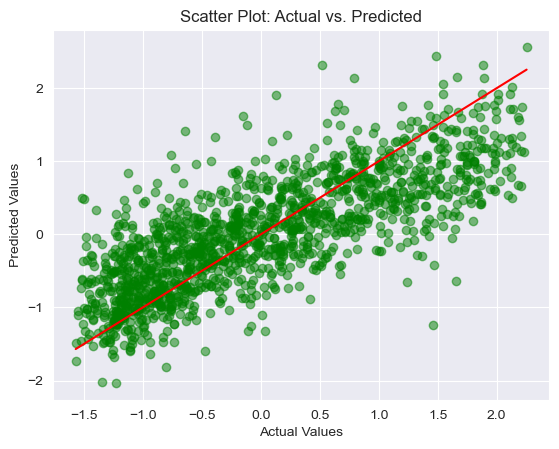

array([-0.60668835, -1.01009657,  0.17328966, ..., -1.0969873 ,
       -0.86024392,  1.41136585])

In [148]:
linear_regression(X_train_1, y_train_1, X_test_1, y_test_1)

Checking for accuracies across few models

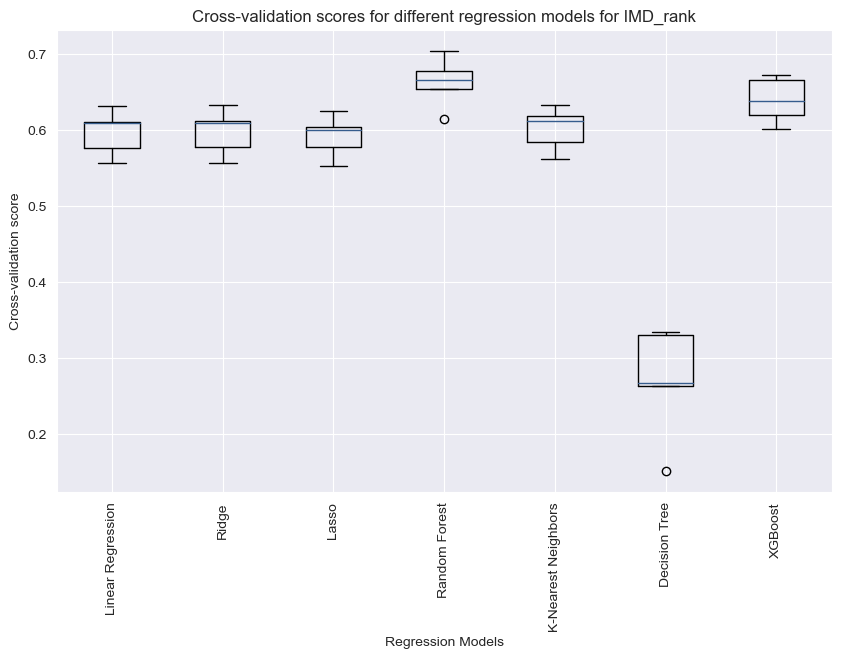

In [227]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import KFold, cross_val_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
## lets find out best regression model for our parameters
models = {"Linear Regression": LinearRegression(), "Ridge": Ridge(alpha=0.001), "Lasso": Lasso(alpha=0.001),"Random Forest": RandomForestRegressor(n_estimators=300),
    "K-Nearest Neighbors": KNeighborsRegressor(),"Decision Tree": DecisionTreeRegressor(random_state=42),"XGBoost": XGBRegressor()}
results = []
# Loop through the models values
for model in models.values():
  kf = KFold(n_splits=5, random_state=42, shuffle=True)
  
  # Perform cross-validation
  cv_scores = cross_val_score(model, X_train_1, y_train_1, cv=kf)
  
  # Append the results
  results.append(cv_scores)
  
# Create a box plot of the results
plt.figure(figsize=(10, 6))
plt.boxplot(results, labels=models.keys())
plt.title("Cross-validation scores for different regression models for IMD_rank")
plt.ylabel("Cross-validation score")
plt.xlabel("Regression Models")
plt.xticks(rotation=90)

#saving fig
plt.savefig('comparing-cv-scores-for-imd.jpg',bbox_inches='tight')

#show plot
plt.show()



We see that non linear models like Random forest and XGB has more accuracy than linear regression


# Random Forest Regressor

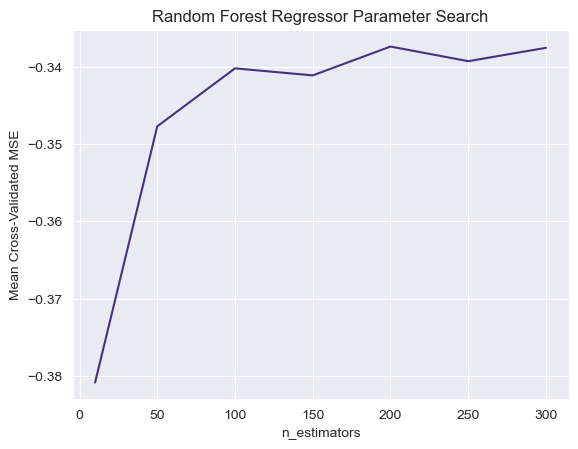

In [150]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
# Define the parameter grid
par_grid = {'n_estimators': [10,50,100,150,200,250,300]}

# Create the RandomForestRegressor model
rfrg = RandomForestRegressor()

# Perform grid search with cross-validation
grid_search = GridSearchCV(rfrg, par_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train_1, y_train_1)

# Get the best parameter value
best_n_estimators = grid_search.best_params_['n_estimators']

# Plot the mean cross-validated scores for each value of n_estimators
scores = grid_search.cv_results_['mean_test_score']
plt.plot(par_grid['n_estimators'], scores)
plt.xlabel('n_estimators')
plt.ylabel('Mean Cross-Validated MSE')
plt.title('Random Forest Regressor Parameter Search')
plt.show()


In [151]:
#Train and evaluate the model with the best parameter value
rfr_best = RandomForestRegressor(n_estimators=best_n_estimators)
rfr_best.fit(X_train_1, y_train_1)
y_pred_rfr_best = rfr_best.predict(X_test_1)
mse_rfr_best = mean_squared_error(y_test_1, y_pred_rfr_best)
r2_rfr_best = r2_score(y_test_1, y_pred_rfr_best)

print("Mean Squared Error (Best):", mse_rfr_best)
print("R-squared score (Best):", r2_rfr_best)

Mean Squared Error (Best): 0.32813297391150614
R-squared score (Best): 0.664025337591406


We get this values of R2 for all the 35 features that were selected earlier.
Now we try and reduce these feature and try to keep the accuracy nearly same as above

#### Feature selection / Feature elimination

In [152]:
# Initialize empty lists to store the number of selected features and corresponding performance metrics
num_features_list = []
mse_list = []
r2_list = []

In [153]:
##performing backward feature elimination with random forest using recurssive feature elimination
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestRegressor

##random forest regressor with best estimators from above
random_for_reg = RandomForestRegressor(n_estimators=best_n_estimators)
##rfcev
select = RFECV(random_for_reg,step=1,cv=5,scoring= 'neg_mean_squared_error')
select.fit(X_train_1,y_train_1)

##select following features from training and test data
X_train_select = select.transform(X_train_1)
X_test_select = select.transform(X_test_1)

##fitting randomforset on selected features
random_for_reg.fit(X_train_select,y_train_1)

##making pred on test data
y_pred_rf = random_for_reg.predict(X_test_select)

##calculating performace matrices
mse_rf = mean_squared_error(y_test_1,y_pred_rf)
r2_rf = r2_score(y_test_1,y_pred_rf)

D:\anaconda\lib\site-packages\sklearn\utils\deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)


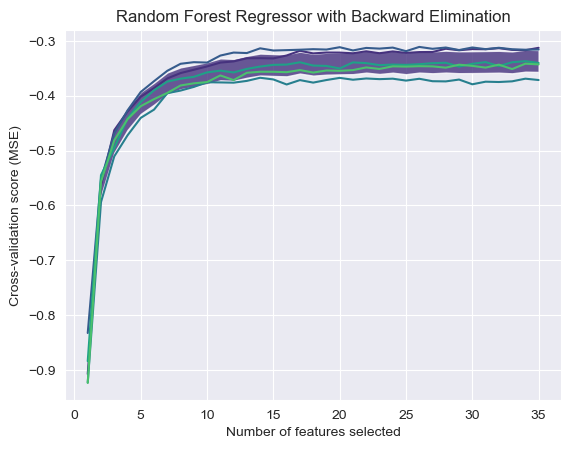

Selected feature names: Index(['weight', 'volume', 'fat', 'saturate', 'salt', 'sugar', 'protein',
       'carb', 'fibre', 'alcohol', 'f_beer', 'f_dairy', 'f_eggs',
       'f_fats_oils', 'f_fish', 'f_fruit_veg', 'f_grains', 'f_meat_red',
       'f_poultry', 'f_readymade', 'f_sauces', 'f_soft_drinks', 'f_spirits',
       'f_sweets', 'f_tea_coffee', 'f_water', 'f_wine', 'male', 'female',
       'age_0_17', 'age_18_64', 'age_65+', 'avg_age', 'num_transactions'],
      dtype='object')
Number of features selected: 34
Mean Squared Error (Random Forest with Feature Selection): 0.3288640008673662
R-squared score (Random Forest with Feature Selection): 0.6632768406275718


In [154]:
# Extract mean cross-validation scores
mean_scores = select.grid_scores_.mean(axis=1)
# Plotting the slected features
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross-validation score (MSE)")
plt.plot(range(1, len(select.grid_scores_) + 1), select.grid_scores_)
plt.fill_between(range(1, len(mean_scores) + 1),
                 mean_scores - select.cv_results_['std_test_score'].mean(),
                 mean_scores + select.cv_results_['std_test_score'].mean(),
                 alpha=0.8)
plt.title("Random Forest Regressor for IMD_rank with Backward Elimination")

##save fig
plt.savefig('Random Forest Regressor for IMD_rank with Backward Elimination.jpg',bbox_inches='tight')

##show
plt.show()

# getting selected feature names
selected_columns = X_train_1.columns[select.support_]

print("Selected feature names:", selected_columns)
print("Number of features selected:", X_train_select.shape[1])
print("Mean Squared Error (Random Forest with Feature Selection):", mse_rf)
print("R-squared score (Random Forest with Feature Selection):", r2_rf)



## Furthure feature reduction
It gives us top selected features but by observing above we can furthure reduce the number of features to 15 to reduce the model complexity and computing time

In [155]:
# getting selected feature names and their importance
feat_imp = random_for_reg.feature_importances_

##sort based on imp
sort_feat = [f for _,f in sorted(zip(feat_imp,selected_columns),reverse= True)]

# select top 15 features
top_15_feat = sort_feat[:15]

# select top 15 features from training and test data
X_train_top_15 = X_train_1[top_15_feat]
X_test_top_15 = X_test_1[top_15_feat]

# fitting random forest on those top 15 features
random_for_reg_top_15 = RandomForestRegressor(n_estimators=best_n_estimators)
random_for_reg_top_15.fit(X_train_top_15, y_train_1)

# making predictions on test data using selected top 15 features
y_pred_rf_top_15 = random_for_reg_top_15.predict(X_test_top_15)

# Calculate performance metrics with top 15 features
mse_rf_top_15 = mean_squared_error(y_test_1, y_pred_rf_top_15)
r2_rf_top_15 = r2_score(y_test_1, y_pred_rf_top_15)

print("Top 15 features:", top_15_feat)
print("Mean Squared Error (Random Forest with Top 10 Features):", mse_rf_top_15)
print("R-squared score (Random Forest with Top 10 Features):", r2_rf_top_15)

Top 15 features: ['avg_age', 'f_water', 'fibre', 'weight', 'f_soft_drinks', 'age_0_17', 'volume', 'f_fish', 'f_fruit_veg', 'f_tea_coffee', 'f_wine', 'f_spirits', 'age_18_64', 'salt', 'f_meat_red']
Mean Squared Error (Random Forest with Top 10 Features): 0.329076883701366
R-squared score (Random Forest with Top 10 Features): 0.6630588703412177


### Hypothesis Testing
H0 = Our selected features and not statistically significant with the target variable
Ha = Our selected features are statistically significant with our target variale
T  =  taget variables (Top 15 features: ['avg_age', 'f_water', 'fibre', 'weight', 'f_soft_drinks', 'age_0_17', 'volume', 'f_fruit_veg', 'f_wine', 'f_fish', 'f_tea_coffee', 'age_18_64', 'salt', 'f_spirits', 'f_meat_red'])

In [156]:
### finding the significance of the selected features
import statsmodels.api as sm
from sklearn.feature_selection import f_regression

# Calculate p-values
_, p_values = f_regression(X_train_top_15, y_train_1)

# Print the p-values
for feature, p_value in zip(top_15_feat, p_values):
    print(f"{feature}: p-value = {p_value}")

avg_age: p-value = 0.0
f_water: p-value = 1.7084269169342478e-249
fibre: p-value = 9.639830388751437e-185
weight: p-value = 1.0716658988201138e-196
f_soft_drinks: p-value = 2.675318517377248e-47
age_0_17: p-value = 1.5583837505861838e-108
volume: p-value = 1.6036188608749898e-71
f_fish: p-value = 3.387726427111086e-09
f_fruit_veg: p-value = 1.5610628273475617e-55
f_tea_coffee: p-value = 4.203144163087615e-11
f_wine: p-value = 1.3828093880234683e-89
f_spirits: p-value = 4.4520217864536274e-23
age_18_64: p-value = 1.3938052516693887e-44
salt: p-value = 8.155871073645682e-22
f_meat_red: p-value = 1.1261646929034492e-41


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_9632\4221212528.py:9: RuntimeWarning:

divide by zero encountered in log10



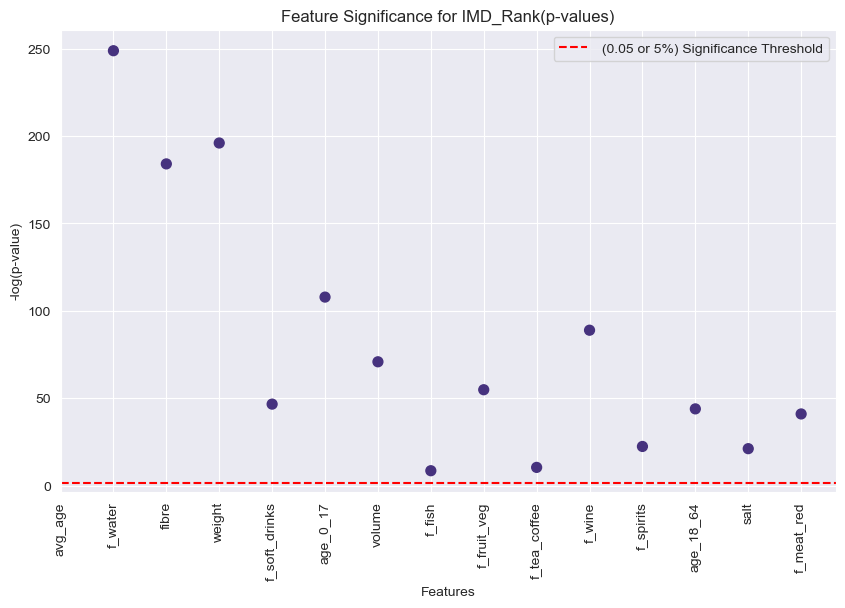

In [229]:
# significance threshold
alpha = 0.05

# Creating an array for marker sizes based on significance
marker_s= np.where(p_values < alpha, 50, 10)

# Create a scatter plot of p-values
plt.figure(figsize=(10, 6))
plt.scatter(range(len(p_values)), -np.log10(p_values), s=marker_s)
plt.xlabel('Features')
plt.ylabel('-log(p-value)')
plt.title('Feature Significance for IMD_Rank(p-values)')
plt.xticks(range(len(top_15_feat)), top_15_feat, rotation=90)
plt.axhline(-np.log10(alpha), color='r', linestyle='--', label=' (0.05 or 5%) Significance Threshold')
plt.legend()

##save fig
plt.savefig('Feature significance for IMD_Rank.jpg',bbox_inches='tight')

##show
plt.show()

Hence We reject H0 (null hypothesis) and we accept our Ha(Alternate hypothesis)and
We find that T (our top 10 features)exhibit a significant correlation with the IMD; all depicted values are significant at the 5% level

#### We can finnaly predict IMD_rank based on 10 features namely ('avg_age', 'f_water', 'fibre', 'weight', 'f_soft_drinks', 'age_0_17', 'f_fish', 'volume', 'f_wine', 'f_fruit_veg') with 65% accuracy

## Exploring  obesity for wards dataset

Main aim over here is to find a pattern from grocery purchase in ward area of london and build a model for predicting obesity in childrens.
For this I have also used data of various other ward profiles for gov data available on https://www.data.gov.uk/dataset/c7869dd4-7a05-4d5d-9e42-bdfc8da8c1b7/ward-profiles-and-atlas/datafile/f32db018-9c20-408d-a599-ef8be84977e7/preview

In [158]:
df_ch_obs = pd.read_csv(r'C:\Users\ADMIN\Desktop\DS_Thesis\Obesity and diabetes dataset\child_obesity_london_ward_2013-2014.csv')
df_wd_pf = pd.read_csv(r'C:\Users\ADMIN\Desktop\DS_Thesis\Obesity and diabetes dataset\ward-profiles.csv',encoding='latin-1')
df_ward_groc = pd.read_csv(r'C:\Users\ADMIN\Desktop\DS_Thesis\Area level Grocery purchase  from Tesco\year_osward_grocery.csv')

In [159]:
df_ward_groc.head()

area_code      weight  weight_perc2.5  weight_perc25  weight_perc50  \
0  E05000026  449.535137            32.5          166.4          300.0   
1  E05000027  413.130263            32.5          150.0          300.0   
2  E05000028  407.100472            32.5          160.0          300.0   
3  E05000029  384.173858            30.0          150.0          250.0   
4  E05000030  356.882607            30.0          140.0          250.0   

   weight_perc75  weight_perc97.5  weight_std  weight_ci95      volume  ...  \
0          500.0           1500.0  771.349423     3.716832  125.960833  ...   
1          500.0           1500.0  626.395178     5.164174  110.664114  ...   
2          500.0           1200.0  545.890959     2.710677  121.990710  ...   
3          454.0           1500.0  591.837557     4.968373  122.245578  ...   
4          450.0           1000.0  465.284180     3.880963  109.959688  ...   

   man_day  population  male  female  age_0_17  age_18_64  age_65+    avg_age  \
0    37315       14370  7469    6901      4211       9421      738  29.572999   
1    14474       10845  5228    5617      3205       6608     1032  33.568004   
2    32138       13856  6750    7106      4180       8537     1139  32.032693   
3    16223       10850  5300    5550      3023       6251     1576  36.004793   
4    17522       11348  5515    5833      2747       6961     1640  37.247444   

   area_sq_km  people_per_sq_km  
0        1.26      11404.761900  
1        1.36       7974.264706  
2        1.29      10741.085270  
3        3.38       3210.059172  
4        3.45       3289.275362  

[5 rows x 202 columns]

In [160]:
df_wd_pf=df_wd_pf.dropna()

In [161]:
df_ch_obs.shape,df_ward_groc.shape

((633, 7), (638, 202))

so there are total of 633 observations for obesity and 638 observations for grocery purchase for  wards of london

In [162]:
##merging
df_merge = df_ch_obs.merge(df_wd_pf,left_on="area_id",right_on="New code",how="inner")
df_merge = df_ward_groc.merge(df_merge,left_on="area_code",right_on="area_id",how="inner")

In [163]:
df_merge.shape

(472, 276)

In [164]:
df_merge=df_merge.dropna()

In [165]:
df_merge.shape

(472, 276)

In [166]:
df_merge.head()

area_code      weight  weight_perc2.5  weight_perc25  weight_perc50  \
0  E05000026  449.535137            32.5          166.4          300.0   
1  E05000027  413.130263            32.5          150.0          300.0   
2  E05000028  407.100472            32.5          160.0          300.0   
3  E05000029  384.173858            30.0          150.0          250.0   
4  E05000030  356.882607            30.0          140.0          250.0   

   weight_perc75  weight_perc97.5  weight_std  weight_ci95      volume  ...  \
0          500.0           1500.0  771.349423     3.716832  125.960833  ...   
1          500.0           1500.0  626.395178     5.164174  110.664114  ...   
2          500.0           1200.0  545.890959     2.710677  121.990710  ...   
3          454.0           1500.0  591.837557     4.968373  122.245578  ...   
4          450.0           1000.0  465.284180     3.880963  109.959688  ...   

   A-Level Average Point Score Per Student - 2013/14  \
0                                              682.6   
1                                              627.9   
2                                              632.0   
3                                              613.9   
4                                              670.1   

   A-Level Average Point Score Per Entry; 2013/14  Crime rate - 2014/15  \
0                                           208.9                 138.1   
1                                           201.6                  73.6   
2                                           207.9                  79.9   
3                                           210.5                  76.1   
4                                           206.8                  66.7   

   Violence against the person rate - 2014/15  \
0                                        42.2   
1                                        27.3   
2                                        27.6   
3                                        24.6   
4                                        24.5   

   Deliberate Fires per 1,000 population - 2014  \
0                                           1.4   
1                                           0.7   
2                                           1.2   
3                                           1.3   
4                                           0.8   

   % area that is open space - 2014  Cars per household - 2011  \
0                              21.9                        0.5   
1                              20.6                        0.8   
2                               1.9                        0.9   
3                              56.0                        0.9   
4                              50.4                        1.1   

   Average Public Transport Accessibility score - 2014  \
0                                                6.0     
1                                                3.1     
2                                                2.9     
3                                                2.3     
4                                                2.3     

   % travel by bicycle to work - 2011  Turnout at Mayoral election - 2012  
0                                 0.8                                25.7  
1                                 1.0                                20.3  
2                                 1.6                                22.5  
3                                 1.2                                25.3  
4                                 1.6                                24.1  

[5 rows x 276 columns]

In [167]:
## observing and picking out necessary columns 
for cols in df_merge.columns:
    print(cols)

area_code
weight
weight_perc2.5
weight_perc25
weight_perc50
weight_perc75
weight_perc97.5
weight_std
weight_ci95
volume
volume_perc2.5
volume_perc25
volume_perc50
volume_perc75
volume_perc97.5
volume_std
volume_ci95
fat
fat_perc2.5
fat_perc25
fat_perc50
fat_perc75
fat_perc97.5
fat_std
fat_ci95
saturate
saturate_perc2.5
saturate_perc25
saturate_perc50
saturate_perc75
saturate_perc97.5
saturate_std
saturate_ci95
salt
salt_perc2.5
salt_perc25
salt_perc50
salt_perc75
salt_perc97.5
salt_std
salt_ci95
sugar
sugar_perc2.5
sugar_perc25
sugar_perc50
sugar_perc75
sugar_perc97.5
sugar_std
sugar_ci95
protein
protein_perc2.5
protein_perc25
protein_perc50
protein_perc75
protein_perc97.5
protein_std
protein_ci95
carb
carb_perc2.5
carb_perc25
carb_perc50
carb_perc75
carb_perc97.5
carb_std
carb_ci95
fibre
fibre_perc2.5
fibre_perc25
fibre_perc50
fibre_perc75
fibre_perc97.5
fibre_std
fibre_ci95
alcohol
alcohol_perc2.5
alcohol_perc25
alcohol_perc50
alcohol_perc75
alcohol_perc97.5
alcohol_std
alcohol_ci95


In [168]:
df_obs = df_merge[['weight','volume','area_id','energy_tot','fat','saturate','salt','sugar','protein','carb','fibre','alcohol','energy_tot','f_beer',
'f_dairy',
'f_eggs',
'f_fats_oils',
'f_fish',
'f_fruit_veg',
'f_grains',
'f_meat_red',
'f_poultry',
'f_readymade',
'f_sauces',
'f_soft_drinks',
'f_spirits',
'f_sweets',
'f_tea_coffee',
'f_water',
'f_wine','male','female','age_0_17','age_18_64','age_65+','avg_age', 'num_transactions','number_reception_measured','number_y6_measured',
'prevalence_overweight_reception',
'prevalence_overweight_y6',
'prevalence_obese_reception',
'prevalence_obese_y6','Mean Age - 2013','In employment (16-64) - 2011',
'Employment rate (16-64) - 2011',
'Number of jobs in area - 2013',
'Employment per head of resident WA population - 2013','Median Household income estimate (2012/13)',
 '% of households with no adults in employment with dependent children - 2011',
'% of lone parents not in employment - 2011',
'(ID2010) - Rank of average score (within London) - 2010','Unauthorised Absence in All Schools (%) - 2013',
'% with no qualifications - 2011',
'% with Level 4 qualifications and above - 2011','A-Level Average Point Score Per Student - 2013/14','Crime rate - 2014/15',
 'Violence against the person rate - 2014/15',
'Deliberate Fires per 1,000 population - 2014',
 'Cars per household - 2011',
'Average Public Transport Accessibility score - 2014',
'% travel by bicycle to work - 2011']]

In [169]:
df_obs.shape

(472, 62)

In [170]:
df_obs.isna().sum()

weight                                                 0
volume                                                 0
area_id                                                0
energy_tot                                             0
fat                                                    0
                                                      ..
Violence against the person rate - 2014/15             0
Deliberate Fires per 1,000 population - 2014           0
Cars per household - 2011                              0
Average Public Transport Accessibility score - 2014    0
% travel by bicycle to work - 2011                     0
Length: 62, dtype: int64

In [171]:
df_obs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 472 entries, 0 to 471
Data columns (total 62 columns):
 #   Column                                                                       Non-Null Count  Dtype  
---  ------                                                                       --------------  -----  
 0   weight                                                                       472 non-null    float64
 1   volume                                                                       472 non-null    float64
 2   area_id                                                                      472 non-null    object 
 3   energy_tot                                                                   472 non-null    float64
 4   fat                                                                          472 non-null    float64
 5   saturate                                                                     472 non-null    float64
 6   salt                                      

In [172]:
# Convert object columns to numeric using .astype()
df_obs['number_reception_measured'] = df_obs['number_reception_measured'].astype(float)
df_obs['number_y6_measured'] = df_obs['number_y6_measured'].astype(float)
df_obs['prevalence_overweight_reception'] = df_obs['prevalence_overweight_reception'].astype(float)
df_obs['prevalence_overweight_y6'] = df_obs['prevalence_overweight_y6'].astype(float)
df_obs['prevalence_obese_reception'] = df_obs['prevalence_obese_reception'].astype(float)
df_obs['prevalence_obese_y6'] = df_obs['prevalence_obese_y6'].astype(float)

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_9632\41878860.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_obs['number_reception_measured'] = df_obs['number_reception_measured'].astype(float)
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_9632\41878860.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_obs['number_y6_measured'] = df_obs['number_y6_measured'].astype(float)
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_9632\41878860.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of 

SELECTING TARGET PREDICTOR.
- which columns to select as our target variables?
so for obestiy as the data for overweight childern will be more varied and much more useful since the children who are obese will also be overweight so lets take overweight as our target variable.
Also for grocery as our predictor we will select 'prevalence_overweight_y6' as our target since the children between age 0-5 have less freedom to what they eat daily.

In [173]:
## trying to predict overweight based on grocery data only
data_groc = df_obs[['prevalence_overweight_y6','weight','volume','energy_tot','fat','saturate','salt','sugar','protein','carb','fibre','alcohol','energy_tot','f_beer',
'f_dairy',
'f_eggs',
'f_fats_oils',
'f_fish',
'f_fruit_veg',
'f_grains',
'f_meat_red',
'f_poultry',
'f_readymade',
'f_sauces',
'f_soft_drinks',
'f_spirits',
'f_sweets',
'f_tea_coffee',
'f_water',
'f_wine','male','female','age_0_17','age_18_64','age_65+','avg_age', 'num_transactions']]

In [174]:
##checking null values
data_groc.isna().sum()

prevalence_overweight_y6    0
weight                      0
volume                      0
energy_tot                  0
energy_tot                  0
fat                         0
saturate                    0
salt                        0
sugar                       0
protein                     0
carb                        0
fibre                       0
alcohol                     0
energy_tot                  0
energy_tot                  0
f_beer                      0
f_dairy                     0
f_eggs                      0
f_fats_oils                 0
f_fish                      0
f_fruit_veg                 0
f_grains                    0
f_meat_red                  0
f_poultry                   0
f_readymade                 0
f_sauces                    0
f_soft_drinks               0
f_spirits                   0
f_sweets                    0
f_tea_coffee                0
f_water                     0
f_wine                      0
male                        0
female    

In [175]:
data_groc.describe()

prevalence_overweight_y6      weight      volume  energy_tot  \
count                472.000000  472.000000  472.000000  472.000000   
mean                   0.359413  370.268091  110.440197  180.308129   
std                    0.061923   49.539418   13.822104    7.557045   
min                    0.173913  255.955618   75.539931  156.104396   
25%                    0.323190  332.697883  100.814666  175.188480   
50%                    0.366432  369.238510  107.979573  179.930786   
75%                    0.407423  408.637272  118.297564  184.862064   
max                    0.493506  513.556945  165.911893  224.388453   

       energy_tot         fat    saturate        salt       sugar     protein  \
count  472.000000  472.000000  472.000000  472.000000  472.000000  472.000000   
mean   180.308129    9.043781    3.554124    0.578411   10.273176    5.272822   
std      7.557045    0.376410    0.174361    0.036016    0.961558    0.223665   
min    156.104396    7.456873    2.920362    0.479774    8.279778    4.399120   
25%    175.188480    8.810529    3.456051    0.552692    9.625869    5.164442   
50%    179.930786    8.993566    3.534377    0.580555   10.114486    5.308618   
75%    184.862064    9.226632    3.627614    0.602281   10.879517    5.423240   
max    224.388453   12.231512    5.111562    0.731715   18.246471    5.951961   

       ...  f_tea_coffee     f_water      f_wine          male        female  \
count  ...    472.000000  472.000000  472.000000    472.000000    472.000000   
mean   ...      0.005912    0.030672    0.016185   6927.968220   7026.904661   
std    ...      0.001048    0.006558    0.006257   1417.337842   1334.780549   
min    ...      0.003572    0.017140    0.004087   2587.000000   2669.000000   
25%    ...      0.005306    0.025407    0.011388   5789.750000   5961.000000   
50%    ...      0.005790    0.030030    0.015585   6823.000000   6944.000000   
75%    ...      0.006386    0.035301    0.019772   7913.000000   7949.250000   
max    ...      0.015504    0.049038    0.042920  14694.000000  12921.000000   

          age_0_17     age_18_64      age_65+     avg_age  num_transactions  
count   472.000000    472.000000   472.000000  472.000000      4.720000e+02  
mean   3148.779661   9166.966102  1639.127119   36.302213      9.968098e+05  
std     888.739900   2070.732612   520.230315    2.876796      1.063751e+06  
min    1027.000000   2885.000000   510.000000   28.666428      3.582100e+04  
25%    2507.500000   7525.500000  1281.000000   34.206021      1.706730e+05  
50%    3022.000000   9137.000000  1534.000000   35.917479      6.568720e+05  
75%    3656.000000  10509.250000  1817.750000   38.159487      1.450626e+06  
max    6690.000000  21657.000000  3527.000000   44.592275      6.509432e+06  

[8 rows x 39 columns]

In [176]:
## we need to normalize the data
data_groc_norm = normalize_with_standard_scaler(data_groc)

In [177]:
X_2 = data_groc_norm.drop('prevalence_overweight_y6',axis=1)
y_2 = data_groc_norm['prevalence_overweight_y6']
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_2, y_2, test_size=0.3, random_state=42)

R2 score (train): 0.6381324772190664
R2 score (test): 0.49467178649031396
Mean squared error: 0.757
model score 0.49467178649031396


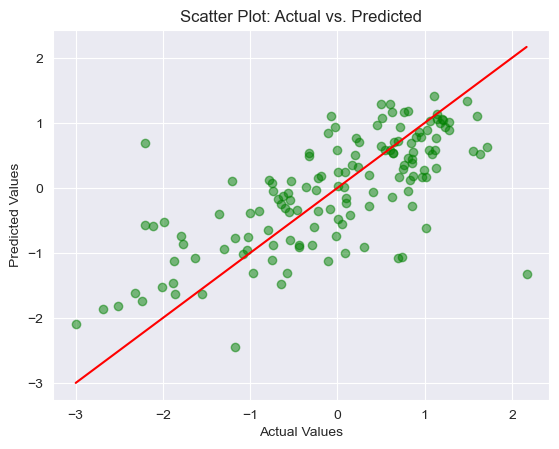

array([ 0.63710722, -0.77766817, -0.88480589,  0.621493  ,  0.32102299,
        0.93221436,  0.1709563 ,  0.55695569,  1.14397523, -2.43902513,
       -0.38915536, -1.47812664,  0.76461134, -0.05890114,  0.44421638,
       -0.16255531,  0.532807  ,  0.17394428,  1.17254038, -1.52135008,
        0.96686357, -1.07339362,  0.58176648,  0.70687333, -0.61901572,
        0.38733321,  1.01374993, -0.74658583, -1.11511722,  0.52712489,
        0.03153404,  0.54115718, -0.59790623, -0.8760043 ,  0.93041857,
        0.58105617, -1.46112166,  0.1084316 ,  0.56035635, -1.62791383,
        1.04077153, -1.08025137,  1.2837053 ,  1.1624777 ,  0.88278044,
        0.57782155,  0.12496258, -0.93782118, -0.35266703,  0.27217162,
       -0.12994767,  0.68878984, -1.02345245, -1.82083987, -0.28470616,
       -1.12309963, -1.6354376 , -1.06643519, -1.3069666 , -1.61272504,
       -0.32034194, -0.90257905,  0.18465066,  1.02365437,  0.17821181,
       -1.74500805,  0.72741497, -1.11652198, -0.2505164 ,  0.58

In [178]:
##linear regression
linear_regression(X_train_2, y_train_2, X_test_2, y_test_2)

As we can see from above that R2 score for train data is higher than test data so it means that our model is overfitting the training data.
On of the possible soluntion to this would be regularization techniques(Lasso or Ridge model).

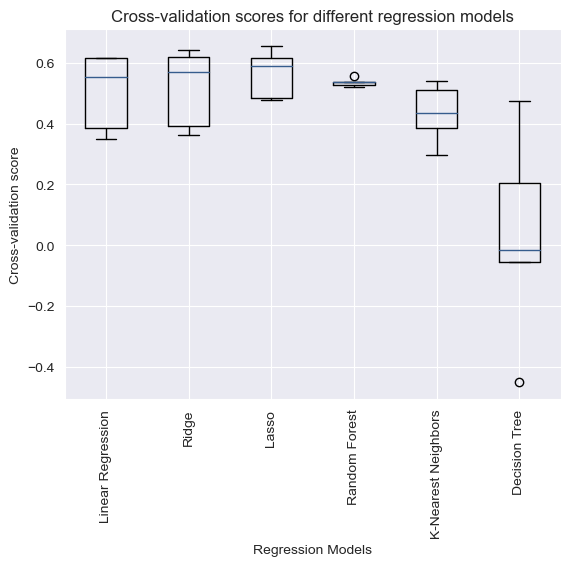

In [179]:
## lets find out
models = {"Linear Regression": LinearRegression(), "Ridge": Ridge(alpha=0.005), "Lasso": Lasso(alpha=0.01),"Random Forest": RandomForestRegressor(n_estimators=300),
          "K-Nearest Neighbors": KNeighborsRegressor(),"Decision Tree": DecisionTreeRegressor(random_state=42)}
results = []
# Loop through the models values
for model in models.values():
    kf = KFold(n_splits=5, random_state=42, shuffle=True)

    # Perform cross-validation
    cv_scores = cross_val_score(model, X_train_2, y_train_2, cv=kf)

    # Append the results
    results.append(cv_scores)

# Create a box plot of the results
plt.boxplot(results, labels=models.keys())
plt.title("Cross-validation scores for different regression models")
plt.ylabel("Cross-validation score")
plt.xlabel("Regression Models")
plt.xticks(rotation=90)
plt.show()

We see that the lasso model fits the best

In [180]:
### writing a fucntion for lasso
def lasso_regression(X_train, y_train, X_test, y_test):
    # Perform Lasso regression
    lasso = Lasso(alpha=0.01)
    lasso_cf = lasso.fit(X_train, y_train).coef_

    # Plot feature coefficients
    names = X_train.columns
    plt.bar(names, lasso_cf)
    plt.xticks(rotation=90)
    plt.show()

    # Make predictions on train set and evaluate the model
    y_train_pred = lasso.predict(X_train)
    r_train = r2_score(y_train, y_train_pred)
    print("R2 score (train):", r_train)

    # Make predictions on test set and evaluate the model
    y_test_pred = lasso.predict(X_test)
    r_test = r2_score(y_test, y_test_pred)
    print("R2 score (test):", r_test)

    ##model score
    lasso_model_score_old = lasso.score(X_test,y_test)
    print('old lasso score',lasso_model_score_old)

    # Find optimal alpha value using grid search
    folds = KFold(n_splits=5, shuffle=True, random_state=42)
    params = {'alpha': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 1.0, 5.0, 10.0]}
    lasso_cv = Lasso()
    model_cv = GridSearchCV(estimator=lasso_cv, param_grid=params, scoring='r2', cv=folds, return_train_score=True, verbose=1)
    model_cv.fit(X_train, y_train)
    best_alpha = model_cv.best_params_['alpha']
    print("Best alpha:", best_alpha)

    # Update the model with the best alpha value
    best_lasso = Lasso(alpha=best_alpha)
    best_lasso.fit(X_train, y_train)

    ##new model score
    lasso_new_model_score = best_lasso.score(X_test,y_test)
    print('new lasso score',lasso_new_model_score)



    # Plot scatter plot for actual and predicted values
    plt.scatter(y_test, y_test_pred, color='blue', alpha=0.5)
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')  # Add a diagonal line for perfect fit
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Scatter Plot: Actual vs. Predicted')
    plt.show()

    return best_lasso.predict(X_test)

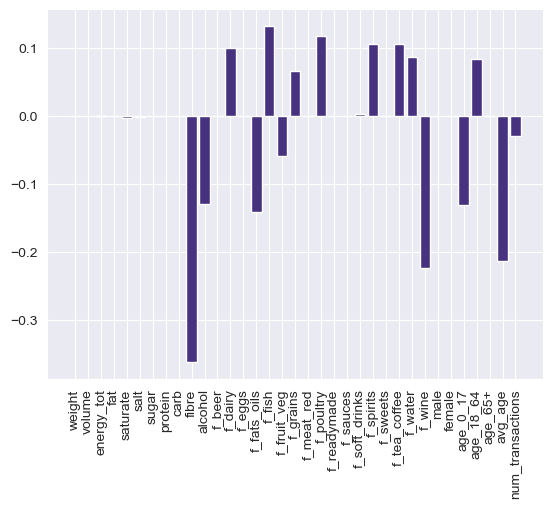

R2 score (train): 0.6226226615623465
R2 score (test): 0.5301267322161435
old lasso score 0.5301267322161435
Fitting 5 folds for each of 10 candidates, totalling 50 fits


D:\anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.123e+01, tolerance: 2.557e-02
  model = cd_fast.enet_coordinate_descent(
D:\anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.406e+01, tolerance: 2.555e-02
  model = cd_fast.enet_coordinate_descent(
D:\anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.107e+01, tolerance: 2.314e-02
  model = cd_fast.enet_coo

Best alpha: 0.01
new lasso score 0.5301267322161435


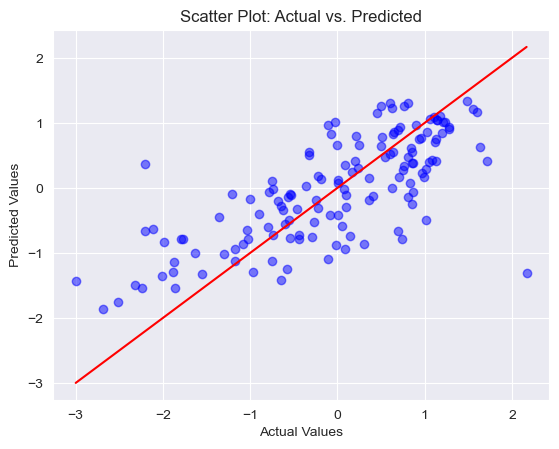

array([ 0.65192479, -0.9449412 , -0.78443852,  0.41450905,  0.30549699,
        1.01467355,  0.29826335,  0.38793029,  1.04480858, -1.12345681,
       -0.16347043, -1.41421854,  0.80279827, -0.11813639,  0.55443813,
       -0.29907508,  0.82256105,  0.23645282,  1.25954928, -1.36214577,
        1.15664917, -0.66917903,  0.70276353,  0.85986728, -0.49696579,
        0.37747948,  0.90178063, -0.87501142, -1.12088806,  0.42902845,
        0.07414566,  0.54975818, -0.52142903, -0.74876711,  0.93048823,
        0.51892866, -1.3008575 , -0.10471915,  1.21449254, -1.33121953,
        1.01298282, -0.99703807,  1.30755666,  1.23343155,  0.93718939,
        0.658699  , -0.05549959, -1.01859038, -0.40116062,  0.17173664,
       -0.33793937,  0.37211649, -0.85803121, -1.75713425, -0.2513714 ,
       -1.1424864 , -1.53532589, -0.78659635, -1.28845019, -1.49211237,
       -0.41058376, -0.71920954,  0.12972379,  1.05793148, -0.05769868,
       -1.54279591,  0.88670695, -1.09023333, -0.28168449,  0.47

In [181]:
lasso_regression(X_train_2, y_train_2, X_test_2, y_test_2)

we get 53% over here but our model still overfits the training data.
So lets explore more features and models

# Trying to extrapolate lsoa imd rank to wards

In [182]:
fp = "C:/Users/ADMIN/Desktop/DS_Thesis/statistical-gis-boundaries-london/ESRI/London_Ward.shp"
shp_gdf = gpd.read_file(fp)
shp_gdf.keys()

Index(['NAME', 'GSS_CODE', 'HECTARES', 'NONLD_AREA', 'LB_GSS_CD', 'BOROUGH',
       'POLY_ID', 'geometry'],
      dtype='object')

In [183]:
shp_gdf.head()

NAME   GSS_CODE  HECTARES  NONLD_AREA  LB_GSS_CD  \
0       Chessington South  E05000405   755.173         0.0  E09000021   
1  Tolworth and Hook Rise  E05000414   259.464         0.0  E09000021   
2              Berrylands  E05000401   145.390         0.0  E09000021   
3               Alexandra  E05000400   268.506         0.0  E09000021   
4                Beverley  E05000402   187.821         0.0  E09000021   

                BOROUGH  POLY_ID  \
0  Kingston upon Thames    50840   
1  Kingston upon Thames   117160   
2  Kingston upon Thames    50449   
3  Kingston upon Thames    50456   
4  Kingston upon Thames   117161   

                                            geometry  
0  POLYGON ((516401.600 160201.800, 516407.300 16...  
1  POLYGON ((517829.600 165447.100, 517837.100 16...  
2  POLYGON ((518107.500 167303.400, 518114.300 16...  
3  POLYGON ((520480.000 166909.800, 520490.700 16...  
4  POLYGON ((522071.000 168144.900, 522063.900 16...

In [184]:
df_lsoa = pd.read_csv(r'C:\Users\ADMIN\Desktop\DS_Thesis\File_1_Imd.csv')

In [185]:
fp1 = "C:/Users/ADMIN/Desktop/DS_Thesis/statistical-gis-boundaries-london/ESRI/LSOA_2011_London_gen_MHW.shp"
shp_gdf1 = gpd.read_file(fp1)
shp_gdf1.keys()

Index(['LSOA11CD', 'LSOA11NM', 'MSOA11CD', 'MSOA11NM', 'LAD11CD', 'LAD11NM',
       'RGN11CD', 'RGN11NM', 'USUALRES', 'HHOLDRES', 'COMESTRES', 'POPDEN',
       'HHOLDS', 'AVHHOLDSZ', 'geometry'],
      dtype='object')

In [186]:
df_lsoa_shp  = shp_gdf1.set_index('LSOA11CD').join(df_lsoa.set_index('lsoa11'))

In [187]:
df_ward_shp = shp_gdf.set_index('GSS_CODE').join(df_merge.set_index('area_code'))

In [188]:
df_ward_shp=df_ward_shp.reset_index()


In [189]:
df_ward_shp.head()

GSS_CODE                    NAME  HECTARES  NONLD_AREA  LB_GSS_CD  \
0  E05000405       Chessington South   755.173         0.0  E09000021   
1  E05000414  Tolworth and Hook Rise   259.464         0.0  E09000021   
2  E05000401              Berrylands   145.390         0.0  E09000021   
3  E05000400               Alexandra   268.506         0.0  E09000021   
4  E05000402                Beverley   187.821         0.0  E09000021   

                BOROUGH  POLY_ID  \
0  Kingston upon Thames    50840   
1  Kingston upon Thames   117160   
2  Kingston upon Thames    50449   
3  Kingston upon Thames    50456   
4  Kingston upon Thames   117161   

                                            geometry      weight  \
0  POLYGON ((516401.600 160201.800, 516407.300 16...  255.955618   
1  POLYGON ((517829.600 165447.100, 517837.100 16...  289.175712   
2  POLYGON ((518107.500 167303.400, 518114.300 16...  274.958028   
3  POLYGON ((520480.000 166909.800, 520490.700 16...  280.714444   
4  POLYGON ((522071.000 168144.900, 522063.900 16...  286.984731   

   weight_perc2.5  ...  A-Level Average Point Score Per Student - 2013/14  \
0            30.0  ...                                              643.4   
1            29.0  ...                                              714.3   
2            28.0  ...                                              733.7   
3            30.0  ...                                              762.2   
4            25.0  ...                                              761.5   

   A-Level Average Point Score Per Entry; 2013/14  Crime rate - 2014/15  \
0                                           203.6                  47.5   
1                                           213.3                  53.7   
2                                           212.9                  31.6   
3                                           215.2                  34.7   
4                                           219.3                  64.5   

   Violence against the person rate - 2014/15  \
0                                        16.3   
1                                        14.2   
2                                         8.2   
3                                         7.9   
4                                        15.4   

   Deliberate Fires per 1,000 population - 2014  \
0                                           0.6   
1                                           0.7   
2                                           0.3   
3                                           0.3   
4                                           0.7   

   % area that is open space - 2014  Cars per household - 2011  \
0                              75.7                        1.4   
1                              33.1                        1.2   
2                              10.9                        1.0   
3                              43.7                        1.4   
4                              26.4                        1.0   

   Average Public Transport Accessibility score - 2014  \
0                                                2.4     
1                                                2.3     
2                                                2.8     
3                                                2.2     
4                                                2.8     

   % travel by bicycle to work - 2011  Turnout at Mayoral election - 2012  
0                                 2.3                                30.4  
1                                 2.9                                32.1  
2                                 4.6                                38.0  
3                                 3.9                                36.3  
4                                 4.4                                41.2  

[5 rows x 283 columns]

In [190]:
df_ward_shp.head()

GSS_CODE                    NAME  HECTARES  NONLD_AREA  LB_GSS_CD  \
0  E05000405       Chessington South   755.173         0.0  E09000021   
1  E05000414  Tolworth and Hook Rise   259.464         0.0  E09000021   
2  E05000401              Berrylands   145.390         0.0  E09000021   
3  E05000400               Alexandra   268.506         0.0  E09000021   
4  E05000402                Beverley   187.821         0.0  E09000021   

                BOROUGH  POLY_ID  \
0  Kingston upon Thames    50840   
1  Kingston upon Thames   117160   
2  Kingston upon Thames    50449   
3  Kingston upon Thames    50456   
4  Kingston upon Thames   117161   

                                            geometry      weight  \
0  POLYGON ((516401.600 160201.800, 516407.300 16...  255.955618   
1  POLYGON ((517829.600 165447.100, 517837.100 16...  289.175712   
2  POLYGON ((518107.500 167303.400, 518114.300 16...  274.958028   
3  POLYGON ((520480.000 166909.800, 520490.700 16...  280.714444   
4  POLYGON ((522071.000 168144.900, 522063.900 16...  286.984731   

   weight_perc2.5  ...  A-Level Average Point Score Per Student - 2013/14  \
0            30.0  ...                                              643.4   
1            29.0  ...                                              714.3   
2            28.0  ...                                              733.7   
3            30.0  ...                                              762.2   
4            25.0  ...                                              761.5   

   A-Level Average Point Score Per Entry; 2013/14  Crime rate - 2014/15  \
0                                           203.6                  47.5   
1                                           213.3                  53.7   
2                                           212.9                  31.6   
3                                           215.2                  34.7   
4                                           219.3                  64.5   

   Violence against the person rate - 2014/15  \
0                                        16.3   
1                                        14.2   
2                                         8.2   
3                                         7.9   
4                                        15.4   

   Deliberate Fires per 1,000 population - 2014  \
0                                           0.6   
1                                           0.7   
2                                           0.3   
3                                           0.3   
4                                           0.7   

   % area that is open space - 2014  Cars per household - 2011  \
0                              75.7                        1.4   
1                              33.1                        1.2   
2                              10.9                        1.0   
3                              43.7                        1.4   
4                              26.4                        1.0   

   Average Public Transport Accessibility score - 2014  \
0                                                2.4     
1                                                2.3     
2                                                2.8     
3                                                2.2     
4                                                2.8     

   % travel by bicycle to work - 2011  Turnout at Mayoral election - 2012  
0                                 2.3                                30.4  
1                                 2.9                                32.1  
2                                 4.6                                38.0  
3                                 3.9                                36.3  
4                                 4.4                                41.2  

[5 rows x 283 columns]

In [191]:
df_lsoa_shp.reset_index(inplace=True)
for cols in df_lsoa_shp.columns:
    print(cols)

LSOA11CD
LSOA11NM
MSOA11CD
MSOA11NM
LAD11CD
LAD11NM
RGN11CD
RGN11NM
USUALRES
HHOLDRES
COMESTRES
POPDEN
HHOLDS
AVHHOLDSZ
geometry
LSOA name (2011)
Local Authority District code (2013)
Local Authority District name (2013)
IMD_Rank
Imd_Decile


# Spatial joining laso and ward dataset to get IMD_rank

Spatial join in Geo pandas enables us to join two datasets based on spatial predicates. For example, you can join a point-based dataset with a polygon-based dataset based on whether the points fall within the polygon. Link :https://www.coiled.io/blog/spatial-join-dask-geopandas-sjoin

In [192]:
df_mer = gpd.sjoin(df_ward_shp, df_lsoa_shp, how='left', op='contains')
df_mer.head()

D:\anaconda\lib\site-packages\IPython\core\interactiveshell.py:3377: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):


GSS_CODE                    NAME  HECTARES  NONLD_AREA  LB_GSS_CD  \
0  E05000405       Chessington South   755.173         0.0  E09000021   
1  E05000414  Tolworth and Hook Rise   259.464         0.0  E09000021   
2  E05000401              Berrylands   145.390         0.0  E09000021   
3  E05000400               Alexandra   268.506         0.0  E09000021   
4  E05000402                Beverley   187.821         0.0  E09000021   

                BOROUGH  POLY_ID  \
0  Kingston upon Thames    50840   
1  Kingston upon Thames   117160   
2  Kingston upon Thames    50449   
3  Kingston upon Thames    50456   
4  Kingston upon Thames   117161   

                                            geometry      weight  \
0  POLYGON ((516401.600 160201.800, 516407.300 16...  255.955618   
1  POLYGON ((517829.600 165447.100, 517837.100 16...  289.175712   
2  POLYGON ((518107.500 167303.400, 518114.300 16...  274.958028   
3  POLYGON ((520480.000 166909.800, 520490.700 16...  280.714444   
4  POLYGON ((522071.000 168144.900, 522063.900 16...  286.984731   

   weight_perc2.5  ...  HHOLDRES  COMESTRES  POPDEN  HHOLDS  AVHHOLDSZ  \
0            30.0  ...       NaN        NaN     NaN     NaN        NaN   
1            29.0  ...    1831.0        0.0    49.8   627.0        2.9   
2            28.0  ...       NaN        NaN     NaN     NaN        NaN   
3            30.0  ...    1397.0        0.0    50.6   497.0        2.8   
4            25.0  ...       NaN        NaN     NaN     NaN        NaN   

            LSOA name (2011)  Local Authority District code (2013)  \
0                        NaN                                   NaN   
1  Kingston upon Thames 017D                             E09000021   
2                        NaN                                   NaN   
3  Kingston upon Thames 014C                             E09000021   
4                        NaN                                   NaN   

   Local Authority District name (2013)  IMD_Rank  Imd_Decile  
0                                   NaN       NaN         NaN  
1                  Kingston upon Thames    24,300         8.0  
2                                   NaN       NaN         NaN  
3                  Kingston upon Thames    31,492        10.0  
4                                   NaN       NaN         NaN  

[5 rows x 303 columns]

In [193]:
df_mer= df_mer[['GSS_CODE', 'IMD_Rank']]

In [194]:
df_mer.shape

(863, 2)

In [195]:
df_mer.isna().sum()

GSS_CODE      0
IMD_Rank    276
dtype: int64

In [196]:
df_ward_shp = df_ward_shp.merge(df_mer, on='GSS_CODE', how='left')

In [197]:
df_ward_shp['IMD_Rank'].isna().sum()

276

In [198]:
df_ward_shp_new = df_ward_shp.dropna()

In [199]:
df_ward_shp_new.shape

(444, 284)

so we get 444 values for imd rank for their corresponding wards

In [200]:
df_ward_shp_new['IMD_Rank'].dtype

dtype('O')

In [201]:
df_ward_shp_new['IMD_Rank']= df_ward_shp_new['IMD_Rank'].str.replace(',', '')

D:\anaconda\lib\site-packages\geopandas\geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [202]:
df_ward_shp_new['IMD_Rank']= df_ward_shp_new['IMD_Rank'].astype(int)

In [203]:
df_ward_shp_new['IMD_Rank'].dtype

dtype('int32')

In [219]:
## renaming columns for ease
df_ward_shp_new = df_ward_shp_new.rename(columns={
    'In employment (16-64) - 2011': 'Employment',
    'Employment rate (16-64) - 2011': 'Employment_rate',
    'Number of jobs in area - 2013': 'Jobs',
    'Employment per head of resident WA population - 2013': 'Employment_per_head',
    'Median Household income estimate (2012/13)': 'Median_income',
    '% of households with no adults in employment with dependent children - 2011': 'No_adults_in_employment',
    '% of lone parents not in employment - 2011': 'Lone_parents_not_employed',
    '(ID2010) - Rank of average score (within London) - 2010': 'area_score_rank',
    'Unauthorised Absence in All Schools (%) - 2013': 'Unauthorised_schoolabsence',
    '% with no qualifications - 2011': 'No_qualifications',
    '% with Level 4 qualifications and above - 2011': 'Level_4_and_above',
    'A-Level Average Point Score Per Student - 2013/14': 'A-Level_point_score',
    'Crime rate - 2014/15': 'Crime_rate',
    'Violence against the person rate - 2014/15': 'Violence_rate',
    'Cars per household - 2011': 'Cars_per_household'
})

In [208]:
## predicting obesity on diet as well as other factors
df_se = df_ward_shp_new[['IMD_Rank','prevalence_overweight_y6', 'Employment', 'Employment_rate',
       'Jobs', 'Employment_per_head', 'Median_income',
       'No_adults_in_employment', 'Lone_parents_not_employed',
       'area_score_rank', 'Unauthorised_schoolabsence',
       'No_qualifications', 'Level_4_and_above',
       'A-Level_point_score', 'Crime_rate',
       'Violence_rate', 'Cars_per_household','weight', 'volume', 'energy_tot', 'fat', 'saturate', 'salt', 'sugar', 'protein', 'carb', 'fibre', 'alcohol', 'f_beer', 'f_dairy', 'f_eggs', 'f_fats_oils', 'f_fish', 'f_fruit_veg', 'f_grains', 'f_meat_red', 'f_poultry', 'f_readymade', 'f_sauces', 'f_soft_drinks', 'f_spirits', 'f_sweets', 'f_tea_coffee', 'f_water', 'f_wine', 'male', 'female', 'age_0_17', 'age_18_64', 'age_65+', 'avg_age', 'num_transactions']]

In [209]:
df_se_norm= normalize_with_standard_scaler(df_se)

In [210]:
df_se_norm.shape

(444, 52)

Initially we take all 52 features and try to build a model to predict obesity then try to reduce features

In [211]:
X_3=df_se_norm.drop('prevalence_overweight_y6',axis=1)
y_3=df_se_norm['prevalence_overweight_y6']
X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split(X_3, y_3, test_size=0.3, random_state=42)

R2 score (train): 0.7743346941144594
R2 score (test): 0.6862447139066856
Mean squared error: 0.592
model score 0.6862447139066856


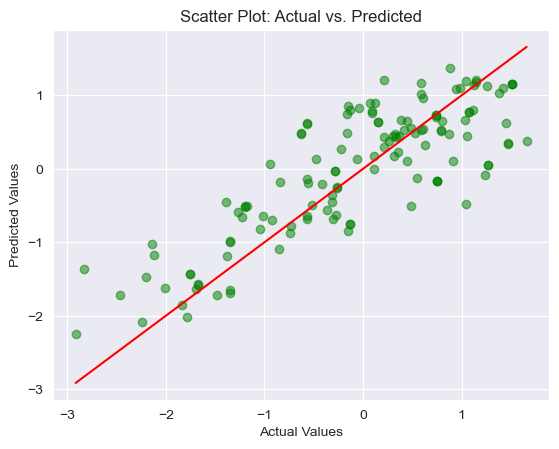

array([-1.18571193,  0.82502927, -0.02300595, -0.47933388, -0.70054287,
       -2.01107045,  0.76232796,  0.7363501 , -0.657966  ,  0.74333843,
        0.47301153, -0.16614966,  0.78358886,  0.04955255, -0.45305616,
        0.65468173,  0.37639982,  0.52326335, -1.43004337,  1.10177515,
       -0.51317995, -0.64365182, -0.2597453 , -1.36005803,  0.48173584,
        0.4431536 ,  0.76798217,  1.13642534,  0.66967241, -0.50322556,
        1.12838369, -0.16750636, -0.12531842,  0.5190421 ,  0.89094854,
       -0.74910886, -1.43321018,  1.01777546,  1.08206129,  0.63641018,
       -0.02213077,  0.47666682, -1.57123812, -0.64239081, -0.68605425,
        0.48386245, -0.17075929,  0.43584179, -1.58549934, -1.71005353,
        1.09435334,  0.61710472, -0.51025038,  1.18127025, -0.82287329,
        0.52389213,  0.61899567, -0.8746893 , -1.68657582, -0.58469986,
        0.77385185, -0.24519939,  1.19985269,  1.1625647 ,  0.73438182,
       -0.00349202, -0.62426216,  1.20836042, -0.4535608 , -1.61

In [212]:
linear_regression(X_train_3,y_train_3,X_test_3,y_test_3)

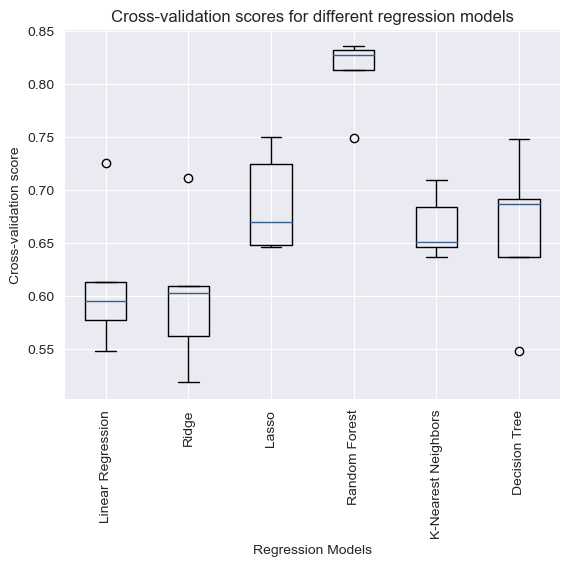

In [213]:
## lets find out best regression model for our parameters
models = {"Linear Regression": LinearRegression(), "Ridge": Ridge(alpha=0.005), "Lasso": Lasso(alpha=0.01),"Random Forest": RandomForestRegressor(n_estimators=300),
    "K-Nearest Neighbors": KNeighborsRegressor(),"Decision Tree": DecisionTreeRegressor(random_state=42)}
results = []
# Loop through the models values
for model in models.values():
  kf = KFold(n_splits=5, random_state=42, shuffle=True)
  
  # Perform cross-validation
  cv_scores = cross_val_score(model, X_train_3, y_train_3, cv=kf)
  
  # Append the results
  results.append(cv_scores)
  
# Create a box plot of the results
plt.boxplot(results, labels=models.keys())
plt.title("Cross-validation scores for different regression models of Obesity")
plt.ylabel("Cross-validation score")
plt.xlabel("Regression Models")
plt.xticks(rotation=90)

##save fig
plt.savefig('Cross-validation scores for different regression models of obesity.jpg',bbox_inches='tight')

##show
plt.show()

We pick random foest as its clear from above it is the best choice

# Random Forest model

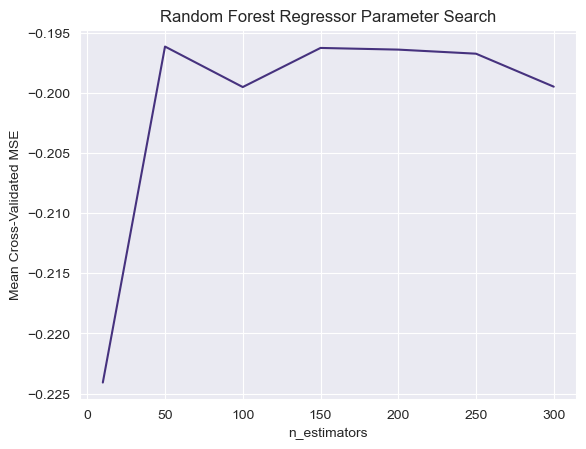

In [214]:
# Define the parameter grid
para_grid = {'n_estimators': [10,50,100,150,200,250,300]}

# Create the RandomForestRegressor model
rand_for = RandomForestRegressor()

# Perform grid search with cross-validation
grid_se = GridSearchCV(rand_for, para_grid, cv=5, scoring='neg_mean_squared_error')
grid_se.fit(X_train_3, y_train_3)

# Get the best parameter value
best_estimators = grid_se.best_params_['n_estimators']

# Plot the mean cross-validated scores for each value of n_estimators
score = grid_se.cv_results_['mean_test_score']
plt.plot(para_grid['n_estimators'], score)
plt.xlabel('n_estimators')
plt.ylabel('Mean Cross-Validated MSE')
plt.title('Random Forest Regressor for Obesity Parameter Search')

##save fig
plt.savefig('Random Forest Regressor for Obesity Parameter Search.jpg',bbox_inches='tight')

##show
plt.show()


In [215]:
#Train and evaluate the model with the best parameter value
rand_for_best = RandomForestRegressor(n_estimators=best_estimators)
rand_for_best.fit(X_train_3, y_train_3)
y_pred_rand_for_best = rand_for_best.predict(X_test_3)
mse_rand_for_best = mean_squared_error(y_test_3, y_pred_rand_for_best)
r2_rand_for_best = r2_score(y_test_3, y_pred_rand_for_best)

print("Mean Squared Error (Best):", mse_rand_for_best)
print("R-squared score (Best):", r2_rand_for_best)

Mean Squared Error (Best): 0.2119546503417103
R-squared score (Best): 0.8103077408846234


In [216]:
# Initialize empty lists to store the number of selected features and corresponding performance metrics
num_features_l = []
mse_l = []
r2_l = []

##performing backward feature elimination with random forest using recurssive feature elimination
#random forest regressor with best estimators from above
rand_for_reg = RandomForestRegressor(n_estimators=best_estimators)
##rfcev
selector = RFECV(rand_for_reg, step=1, cv=5, scoring='neg_mean_squared_error')
selector.fit(X_train_3, y_train_3)

##select following features from training and test data
X_train_selected = selector.transform(X_train_3)
X_test_selected = selector.transform(X_test_3)

##fitting randomforset on selected features
rand_for_reg.fit(X_train_selected, y_train_3)

##making pred on test data
y_pred_rand_for = rand_for_reg.predict(X_test_selected)

##calculating performace matrices
mse_rand_for = mean_squared_error(y_test_3, y_pred_rand_for)
r2_rand_for = r2_score(y_test_3, y_pred_rand_for)


D:\anaconda\lib\site-packages\sklearn\utils\deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)


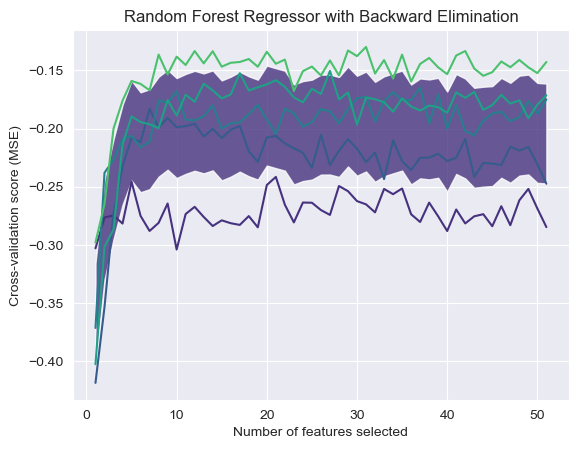

Selected feature names: Index(['Employment_rate', 'Median_income', 'No_adults_in_employment',
       'Lone_parents_not_employed', 'area_score_rank', 'A-Level_point_score',
       'Violence_rate', 'Cars_per_household', 'volume', 'fibre', 'f_eggs',
       'f_fish', 'f_sauces', 'f_spirits', 'f_water', 'f_wine', 'female',
       'age_0_17', 'age_65+', 'avg_age'],
      dtype='object')
Number of features selected: 20
Mean Squared Error (Random Forest with Feature Selection): 0.22125899461991477
R-squared score (Random Forest with Feature Selection): 0.8019806667540281


In [217]:
# Extract mean cross-validation scores
mean_score = selector.grid_scores_.mean(axis=1)
# Plotting the slected features
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross-validation score (MSE)")
plt.plot(range(1, len(selector.grid_scores_) + 1), selector.grid_scores_)
plt.fill_between(range(1, len(mean_score) + 1),
                 mean_score - selector.cv_results_['std_test_score'].mean(),
                 mean_score + selector.cv_results_['std_test_score'].mean(),
                 alpha=0.8)
plt.title("Random Forest Regressor for Obesity with Backward Elimination")

##save fig
plt.savefig('Random Forest Regressor for Obesity with Backward Elimination.jpg',bbox_inches='tight')

##show
plt.show()

# getting selected feature names
selected_column = X_train_3.columns[selector.support_]

print("Selected feature names:", selected_column)
print("Number of features selected:", X_train_selected.shape[1])
print("Mean Squared Error (Random Forest with Feature Selection):", mse_rand_for)
print("R-squared score (Random Forest with Feature Selection):", r2_rand_for)

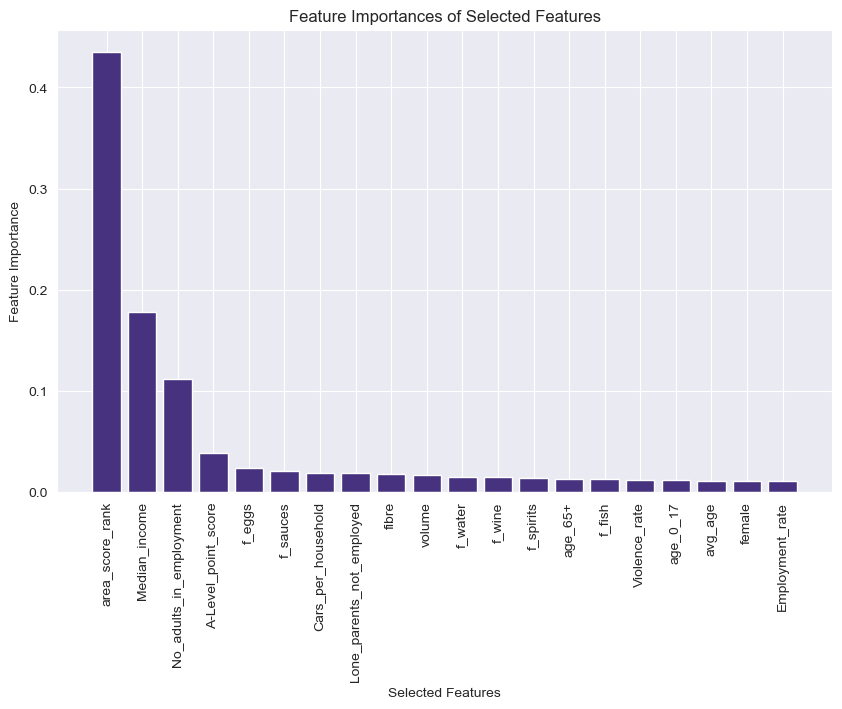

In [218]:
## getting feature importance and their names
imp_feat = rand_for_reg.feature_importances_

## sorting based on imp
sorted_feat = np.argsort(imp_feat)[::-1]
sorted_features_names = selected_column[sorted_feat]
sorted_features_importances = imp_feat[sorted_feat]

# Plotting the selected features and their importance
plt.figure(figsize=(10, 6))
plt.bar(sorted_features_names, sorted_features_importances)
plt.xticks(rotation=90)
plt.xlabel("Selected Features")
plt.ylabel("Feature Importance")
plt.title("Feature Importances of Selected Features for obesity")

##savefig
plt.savefig('Feature Importances of Selected Features for obesity.jpg',bbox_inches='tight')

##show
plt.show()




Hence we can predict obesity in children with around 81% accuracy using 10-20 features from above